In [1]:
import numpy as np
import pptk
import networkx as nx
import imageio
import glob
import re
from random import sample, seed
from scipy.spatial import distance
from time import strftime
import os
import scipy.optimize as optimize
import math
from sklearn.linear_model import LinearRegression
import time
import copy
from moving_least_square import *
from tempfile import TemporaryFile
from collections import defaultdict
from vpython import *
from math import *
scene = canvas()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
seed(17)
if os.name == 'nt': # Windows
    system_win = 1
else:
    system_win = 0

In [3]:
# Given the data points, return the MST of the point cloud generated from the PNG files and an array 
# of points positions
# Param: data: an array of points coordinate. Each point's coordinate should has the format of [x, y, z]
#        drawMST: boolean value. Default is false. If set true, the function will also draw a MST graph at the end
#        sampleNumber: int value. Default is 5000. This function will only sample <sampleNumber> points from the data
# Return: a NetworkX graph representing the Minimum spanning tree of the data points
def getMSTFromDataPoint(data, drawMST: bool=False, sampleNumber: int=5000):
    # Read points data from PNGs 
    if(sampleNumber > len(data)):
        sampleNumber = len(data)
        
    # default sample 5000 points from the whole set, otherwise it would take too long
    print("---------------")
    print("There are " + str(len(data)) + " points in total. Now sampleling " + str(sampleNumber) + " points from them")
    sample_data = np.asarray(sample(list(data), sampleNumber))
    print("---------------")
    print("Done!")
    
    #display the points 
    #displayPoints(sample_data, 1.3)
    
    #Create a networkX graph instance that represent MST
    print("---------------")
    print("Begin creating a MST of the sampled points cloud")
    MST = CreateMSTGraph(sample_data)
    print("---------------")
    print("MST creation Done!")
    
    if(drawMST):
        nx.draw(MST, dict(enumerate(sample_data[:, :2])))
        
    return (MST, sample_data)
    

In [4]:
# This function will invoke a pptk viewer to render the points 
# Param: data: an array of points coordinate. Each point's coordinate should has the format of [x, y, z]
#       pointSize: the size of the point to be rendered on the screen
# Return: none

def displayPoints(data, pointSize):
    v = pptk.viewer(data)
    v.set(point_size=pointSize)

In [5]:
# This function will read a txt file and convert its content to point data, which is an array of points coordinate. 
# Each point's coordinate should has the format of [x, y, z]
# Param: filePath: the file path of the txt file
# Return: an array of points coordinate. Each point's coordinate has the format of [x, y, z]
def readPointFromTXT(filePath):
    data = np.genfromtxt(fname=filePath, skip_header=0)
    return data

In [6]:
# This function will read a series of PNG file and convert its content to point data, which is an array of points coordinate. 
# Each point's coordinate will have the format of [x, y, z]
# Param: filePath: the file path of the PNG files. Each file should be named as 1.png, 2.png, 3.png ... etc. All the png file should 
# be ordered by the their topological order from their original dicom file
# Return: an array of points coordinate. Each point's coordinate has the format of [x, y, z]
def ReadPointFromPNG(filepath):
    print("---------------")
    print("Begin reading points data from PNG files")
    path_list = [im_path for im_path in glob.glob(filepath)]
    
    if system_win:
        path_list_parsed = [re.split('\\\\|\.', path) for path in path_list]
    else:
        path_list_parsed = [re.split('/|\.', path) for path in path_list]
    path_list_parsed_valid = [x for x in path_list_parsed if x[-1] == 'png']
    path_list_parsed_valid = sorted(path_list_parsed_valid, key=lambda x:int(x[-2]))
    
    print("There are", len(path_list_parsed_valid),"PNG files, now convert them to point coordinates in 3D")
    imageData = []
    delta = 0.5
    totalThickness = len(path_list_parsed_valid) * 3 * delta
    for path in path_list_parsed_valid:
        s = ""
        if system_win:
            s = "\\"
        else:
            s = "/"
        s = s.join(path)
        s = s[:-4] + '.png'
        image = imageio.imread(s)
        imageData.append(image)
    
    zxy = np.transpose(np.where(imageData))
    xyz = zxy[:, [1, 2, 0]]
    xyz[:, 2] = totalThickness - xyz[:, 2]*3*delta
    print("Done!")
    return xyz

In [7]:
# This function is used to limited the number of edges in the original graph.
# Instead of creating a graph with full connectivity, this function will return 
# a list of neighbor points for each point and we will only connect them in the graph
def getNearbyPoints(pointsData):
    D = distance.squareform(distance.pdist(pointsData))
    closestIndicies = np.argsort(D, axis=1)
    closestDis = np.sort(D, 1)
    threshold = 10 # This number can be changed. The greater this number, the more edges
    return (closestIndicies[:, 1:threshold], closestDis[:, 1:threshold])

In [8]:
def CreateMSTGraph(pointsData):
    print("---------------")
    print("Begin calculating nearby points for each point")
    nearbyInfo = getNearbyPoints(pointsData)
    print("---------------")
    print("Nearby points calculation Done!")
    print("---------------")
    print("Begin construct graph")
    G=nx.Graph()
    closestIndicies = nearbyInfo[0]
    closestDis = nearbyInfo[1]
    for firstPIndex in range(len(closestIndicies)):
        for second in range(len(closestIndicies[firstPIndex])):
            secondPIndex = closestIndicies[firstPIndex][second]
            G.add_edge(firstPIndex, secondPIndex , weight = closestDis[firstPIndex][second])
    print("---------------")
    print("Graph construction Done!")
    print("---------------")
    print("Begin calculate MST")
    G = nx.minimum_spanning_tree(G)
    print("---------------")
    print("MST calculation Done!")
    return G

In [9]:
# Impliment the collect algorithm for 3D points in the paper
def collectPoints1(P: int, PStar: int):
    global H_glo
    global graph
    global pointsCor3D
    global A

    A.append(P)
    for edge in graph.edges(P):
        Pj = edge[1]
        if(Pj) not in A and distance.euclidean(pointsCor3D[Pj], pointsCor3D[PStar]) < H_glo:
            collectPoints1(Pj, PStar)

In [10]:
# This function will collect the neighbors of PStar and return a list of this points's index
# Param: PStar: the index of the point that we want to find its neighbors
# This function will also maintain the dictionary of the distance between points and the weight 
# between points. 
def collectPointsNonrec(PStar: int, H:int):
    
    global graph
    global pointsCor3D
    global distance_dict 
    global dirty_dict
    
    toExplore = [PStar]
    A = [PStar]
    distance_dict[(PStar, PStar)] = 0
    weight_dict[((PStar, PStar))] = 1
    
    while len(toExplore) > 0:
        curP = toExplore[0]
        del toExplore[0]
        for Pj in graph.neighbors(curP):
            if(Pj) not in A:
                
                # Maintain the dictionary of distance and weight between points
                if (Pj, PStar) not in distance_dict or (PStar, Pj) not in distance_dict or \
                dirty_dict[PStar] == 1 or dirty_dict[Pj] == 1:
                    dist_temp = distance.euclidean(pointsCor3D[Pj], pointsCor3D[PStar])
                    distance_dict[(Pj, PStar)] = dist_temp
                    distance_dict[(PStar, Pj)] = dist_temp
                    weight_dict[((PStar, Pj))] = weightFun(PStar, Pj)
                    weight_dict[((Pj, PStar))] = weightFun(PStar, Pj)
                    dirty_dict[Pj] = 0
                    dirty_dict[PStar] = 0
                    
                if distance_dict[(Pj, PStar)] < H:
                    toExplore.append(Pj)
                    A.append(Pj)
    return A

In [11]:
def weightFun(P1, P2):
    global distance_dict 
    global dirty_dict
    global pointsCor3D
    if(P1 == P2):
        return 1
    return math.exp(-1 * (distance_dict[(P1, P2)]**2)/(H_glo**2))

In [25]:
def calculateRegressionPlane(PStar, A: list):
    global pointsCor3D
    global H_glo
    global weight_dict
    global curPlaneGuess
    #global curScalar
    #global curALen
    '''
    weightKeyList = [(PStar, x) for x in A[curALen:]]
    wM = np.array([weight_dict[k] for k in weightKeyList])
    
    xMatrix = np.array([pointsCor3D[point][0] for point in A[curALen:]])
    yMatrix = np.array([pointsCor3D[point][1] for point in A[curALen:]])
    zMatrix = np.array([pointsCor3D[point][2] for point in A[curALen:]])
    scalarList = np.array([np.sum(xMatrix**2*wM), 2*np.sum(xMatrix*yMatrix*wM), 2*np.sum(xMatrix*wM), \
                           -2*np.sum(xMatrix*zMatrix*wM), np.sum(yMatrix**2*wM), 2*np.sum(yMatrix*wM), \
                           -2*np.sum(yMatrix*zMatrix*wM), np.sum(wM) ,-2*np.sum(zMatrix*wM), \
                           np.sum(zMatrix**2*wM)]) + curScalar
    '''
    
    weightKeyList = [(PStar, x) for x in A]
    wM = np.array([weight_dict[k] for k in weightKeyList])
    
    xMatrix = np.array([pointsCor3D[point][0] for point in A])
    yMatrix = np.array([pointsCor3D[point][1] for point in A])
    zMatrix = np.array([pointsCor3D[point][2] for point in A])
    
    def f(params):
        a, b, c = params 
        loss = sum(((a * xMatrix + b*yMatrix + c - zMatrix)**2)*wM)
        #loss = a**2*scalarList[0] +  a*b*scalarList[1] + a*c*scalarList[2] + a*scalarList[3] + b**2*scalarList[4]\
        #+ b*c*scalarList[5] + b*scalarList[6] + c**2*scalarList[7] + c*scalarList[8] + scalarList[9]
        
        '''
        for point in A:
            point_cor = pointsCor3D[point]
            loss += ((a*point_cor[0] + b*point_cor[1] + c - point_cor[2])**2)*weight_dict[((point, PStar))]
            #loss += ((a*point_cor[0] + b*point_cor[1] + c - point_cor[2])**2)*weightFun(PStar, point)
        '''
        return loss
    
    result = optimize.minimize(f, curPlaneGuess, method = 'Nelder-Mead')
    
    if result.success:
        fitted_params = result.x
    else:
        raise ValueError(result.message)
        
    curPlaneGuess = fitted_params
    #curScalar = scalarList
    #curALen = len(A)
    
    return fitted_params

In [13]:
def projectPoints(params, A: list):
    global pointsCor3D
    a, b, c = params
    normal = np.asarray([a, b, -1])
    normal = normal / np.linalg.norm(normal)
    pointOnPlane = np.asarray([0, 0, c])
    projectionPointsCor = []
    for point in A:
        point_cor = np.asarray(pointsCor3D[point])
        pointToPlaneV = point_cor - pointOnPlane
        dist = np.dot(normal, pointToPlaneV)
        projectionPointcor = point_cor - dist*normal
        projectionPointsCor.append(list(projectionPointcor))
    return projectionPointsCor

In [14]:
# this function converted the 3D coordinate system of points in a plane to 2D, returns a list of new coordinates
# each of them also has x, y and z component but z is equal to 0
# this finction also will return the info of the plane, which can be used to convert a 2D coordinate to 3D again
# The format of the plane info is [u, v, origin] (u is a unit vector in 3D representing plane's x axis, y is a unit 
# vector in 3D representing plane's y axis, origin is a coordinate in 3D of plane's origin )
def convertTo2DCor(pointsCor, planeParam):
    a, b, c = planeParam
    origin = np.array([0, 0, c])
    u = np.array([0, 0, c]) - np.array([1, 1, a + b + c])
    u = u / np.linalg.norm(u)
    normal = np.array([a, b, -1])
    v = np.cross(u, normal)
    v = v / np.linalg.norm(v)
    convertedPointsCor = []
    
    for pointCor in pointsCor:
        oriV = np.array(pointCor) - origin
        new_x = np.dot(oriV, u)
        new_y = np.dot(oriV, v)
        convertedPointsCor.append([new_x, new_y, 0])
        
    planeInfo = [u, v, origin]
    
    return (convertedPointsCor, planeInfo)
    

In [15]:
# Param: targetPoint: the index of the point that we want to find its neighbors and their coordinate in 2D 
# Return: the 2D coordinate of the 3D points and the information of the regression plane, which the points are located
# require gloable perameters graph and pointsCor3D

def get2DCorFrom3D(targetPoint):
    
    global graph
    global pointsCor3D
    global H_glo
    global H_delta
    global min_neighbors
    
    localPoints = []

    while (len(localPoints) < min_neighbors):
        localPoints = collectPointsNonrec(targetPoint, H_glo)
        H_glo += H_delta

    params = calculateRegressionPlane(targetPoint, localPoints)

    projectionPointsCor = projectPoints(params, localPoints)

    points2DCor, planeInfo = convertTo2DCor(projectionPointsCor, params)

    return (points2DCor, planeInfo)

In [16]:
# This function takes a single point's 2D coordinate and transform it into 3D base on the planeInfo
def get3DCorFrom2D(pointCor, planeInfo):
    u, v, origin = planeInfo
    vectorElem1 = pointCor[0]*u
    vectorElem2 = pointCor[1]*v
    newCor = vectorElem1 + vectorElem2 + origin
    
    return newCor

In [17]:
#compue the line regression
def calculateRegressionLine(pointsCor):
    X = np.array([x[0] for x in pointsCor]).reshape(-1, 1)
    Y = np.array([x[1] for x in pointsCor]).reshape(-1, 1)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    
    return(linear_regressor.coef_[0], linear_regressor.intercept_[0])

In [18]:
def rotatePointsCor(pointsCor, lineCoef):
    pointsCor = np.array(pointsCor)
    theta = math.atan(lineCoef)
    c, s = math.cos(theta), math.sin(theta)
    R = np.array([(c,-s, 1), (s, c, 1)])
    newPointsCor = []
    
    for point in pointsCor:
        newPointsCor.append(R.dot(point))
    return np.asarray(newPointsCor)

In [19]:
def deleteChild(child:int):
    global removedNodeDict
    global graph_centerline
    global pointsCor3D_centerline
    
    graph_centerline.remove_node(child)
    
    if(child not in removedNodeDict):
        return
    
    for grandChild in removedNodeDict[child]:
        deleteChild(grandChild)

In [20]:
def addBackChildren(parent:int, curDepth:int):
    global removedNodeDict
    global graph_centerline
    global pointsCor3D_centerline
    
    if(parent not in removedNodeDict):
        return curDepth
    
    if(len(removedNodeDict[parent]) == 1):
        child = removedNodeDict[parent][0]
        parent_cor = pointsCor3D_centerline[parent]
        child_cor = pointsCor3D_centerline[child]
        graph_centerline.add_edge(parent, child , weight=distance.euclidean(parent_cor, child_cor))
        return addBackChildren(removedNodeDict[parent][0], curDepth + 1)
    
    else:
        maxDepth = 0
        curChild = -1
        
        for child in removedNodeDict[parent]:
            child = removedNodeDict[parent][0]
            parent_cor = pointsCor3D_centerline[parent]
            child_cor = pointsCor3D_centerline[child]
            graph_centerline.add_edge(parent, child , weight=distance.euclidean(parent_cor, child_cor))
            childDepth = addBackChildren(removedNodeDict[parent][0], curDepth + 1)
            
            if(childDepth < maxDepth):
                deleteChild(child)
            else:
                maxDepth = childDepth
                
                if(curChild != -1):
                    deleteChild(curChild)
                    
                curChild = child           
        return maxDepth
     

In [21]:
def pointCorToVector(pointCor):
    x = pointCor[0]
    y = pointCor[1]
    z = pointCor[2]
    return vector(x, y, z)

In [22]:
# Uncomment the next line if want to reload from file
filePath = "mri_label_2016/*.png"
pointData = ReadPointFromPNG(filePath)

# the temp.npy stores the colon data points from 2016 model
#pointData = np.load('./temp.npy')
(graph, pointsCor3D) = getMSTFromDataPoint(pointData, drawMST=False, sampleNumber=5000)

---------------
Begin reading points data from PNG files
There are 144 PNG files, now convert them to point coordinates in 3D
---------------
Begin reading points data from PNG files
There are 144 PNG files, now convert them to point coordinates in 3D
Done!
---------------
There are 818757 points in total. Now sampleling 5000 points from them
---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
Done!
---------------
There are 818757 points in total. Now sampleling 5000 points from them
---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
---------------
Nearby points calculation Done!
---------------
Begin construct graph
---------------
Nearby points calculation Done!
---------------
Begin construct graph
---------------
Graph construction Done!
---------------
Begin calculate MST
-------------

In [23]:
displayPoints(pointsCor3D, 1.3)

In [51]:
# the code to move points toward the centerline 
points_centerline = []
# The total number of iterations
for iteration in range(2):
    points_centerline = []
    H_ini = 15
    H_delta = 5
    H_glo = 0
    trial_limit =10
    min_neighbors = 80
    max_neighbors = 750
    correlation_threshold = 0.2 + iteration*0.05
    weight_dict = {}
    distance_dict = {}

    # Set up a dirty dictionary to record the points 
    dirty_dict = {}
    for point in range(len(pointsCor3D)):
        dirty_dict[point] = 0
    results = []
    
    # We will move 750 points of all the points for each iteration
    for targetPoint in range(1000, 1750):
        
        cur_correlation = 0
        H_glo = H_ini
        trial = 0
        correlation_hist = []
        localPointsCor2D_hist = []
        planeInfo = 0
        localPointsCor2D = []
        curPlaneGuess = [1, 1, 1]
        #curScalar = np.zeros(10)
        #curALen = 0
        
        # if the correlation of the local points is not sufficient or the number of the local points is not sufficient
        # enlarge H_glo and find neighbors again  
        while(cur_correlation < correlation_threshold and len(localPointsCor2D) < max_neighbors \
               and trial < trial_limit):
            
            curPlaneGuess = [1, 1, 1]
            localPointsCor2D, planeInfo = get2DCorFrom3D(targetPoint)
            
            slope, intersept = calculateRegressionLine(localPointsCor2D)
            rotatedPointsCor = rotatePointsCor(localPointsCor2D, slope)
            cur_correlation = abs(np.corrcoef(rotatedPointsCor[:, 0],rotatedPointsCor[:, 1])[0][1])
            print(targetPoint, "trial",str(trial), "H =", H_glo, ":" , str(cur_correlation), \
                  "size:", len(localPointsCor2D))
            H_glo += H_delta
            trial += 1
            correlation_hist.append(cur_correlation)
            localPointsCor2D_hist.append(copy.deepcopy(localPointsCor2D))
            
        localPointsCor2D = localPointsCor2D_hist[correlation_hist.index(max(correlation_hist))]
        centerPoint2D = np.asarray(localPointsCor2D)[:1, :2]
        newCor = Moving_Least_Square(centerPoint2D[0], np.asarray(localPointsCor2D)[:, :2])
        newCor3D = get3DCorFrom2D(newCor, planeInfo)
        print(pointsCor3D[targetPoint], newCor3D)
        pointsCor3D[targetPoint] = list(newCor3D)
        dirty_dict[targetPoint] = 1
        results.append(max(correlation_hist))
        points_centerline.append(newCor3D)
        
    displayPoints(points_centerline, 0.5)    

1000 trial 0 H = 35 : 0.10214487457324882 size: 94
1000 trial 1 H = 45 : 0.22490996270088975 size: 154
[274 147 135] [278.72400543 151.20737895 133.55971568]
1001 trial 0 H = 30 : 0.2778117523023022 size: 81
[331 371 148] [331.74879    371.74196919 148.29728923]
1002 trial 0 H = 30 : 0.005298250293400363 size: 85
1002 trial 1 H = 40 : 0.6805819995404818 size: 134
[319 395 148] [319.12338687 395.1255396  148.34782383]
1003 trial 0 H = 35 : 0.05022584987073404 size: 99
1000 trial 0 H = 35 : 0.10214487457324882 size: 94
1000 trial 1 H = 45 : 0.22490996270088975 size: 154
[274 147 135] [278.72400543 151.20737895 133.55971568]
1001 trial 0 H = 30 : 0.2778117523023022 size: 81
[331 371 148] [331.74879    371.74196919 148.29728923]
1002 trial 0 H = 30 : 0.005298250293400363 size: 85
1002 trial 1 H = 40 : 0.6805819995404818 size: 134
[319 395 148] [319.12338687 395.1255396  148.34782383]
1003 trial 0 H = 35 : 0.05022584987073404 size: 99
1003 trial 1 H = 45 : 0.611939403378735 size: 198
[390 2

1025 trial 0 H = 25 : 0.2242987380140034 size: 117
[248  78 154] [247.28952631  77.48695242 155.36367509]
1026 trial 0 H = 30 : 0.1914385066848886 size: 137
1026 trial 1 H = 40 : 0.041248557130019486 size: 370
1026 trial 2 H = 50 : 0.08503089337837236 size: 749
1026 trial 3 H = 60 : 0.047868812070055035 size: 1001
[206 102 160] [242.16443341 133.85184577 158.61932874]
1027 trial 0 H = 25 : 0.18074016552243202 size: 91
1027 trial 1 H = 35 : 0.16876892065980625 size: 249
1027 trial 2 H = 45 : 0.2291289420050727 size: 340
[236  80 154] [234.13702424  78.27850565 154.94339323]
1028 trial 0 H = 35 : 0.044400725365274986 size: 85
1026 trial 3 H = 60 : 0.047868812070055035 size: 1001
[206 102 160] [242.16443341 133.85184577 158.61932874]
1027 trial 0 H = 25 : 0.18074016552243202 size: 91
1027 trial 1 H = 35 : 0.16876892065980625 size: 249
1027 trial 2 H = 45 : 0.2291289420050727 size: 340
[236  80 154] [234.13702424  78.27850565 154.94339323]
1028 trial 0 H = 35 : 0.044400725365274986 size: 8

1049 trial 3 H = 65 : 0.03586419291192357 size: 860
[177 150 165] [173.28481325 146.31642144 162.83091477]
1050 trial 0 H = 35 : 0.04572055670979105 size: 93
1050 trial 1 H = 45 : 0.20307769795929295 size: 161
[385 301 158] [386.04420966 301.96597744 158.09694478]
1051 trial 0 H = 30 : 0.02667946608771788 size: 166
1051 trial 1 H = 40 : 0.1087620869545004 size: 309
1051 trial 2 H = 50 : 0.017879368455527598 size: 363
1049 trial 3 H = 65 : 0.03586419291192357 size: 860
[177 150 165] [173.28481325 146.31642144 162.83091477]
1050 trial 0 H = 35 : 0.04572055670979105 size: 93
1050 trial 1 H = 45 : 0.20307769795929295 size: 161
[385 301 158] [386.04420966 301.96597744 158.09694478]
1051 trial 0 H = 30 : 0.02667946608771788 size: 166
1051 trial 1 H = 40 : 0.1087620869545004 size: 309
1051 trial 2 H = 50 : 0.017879368455527598 size: 363
1051 trial 3 H = 60 : 0.005259541094268088 size: 417
1051 trial 4 H = 70 : 0.09171570094847285 size: 440
1051 trial 5 H = 80 : 0.3415926228830306 size: 496
[3

1072 trial 1 H = 35 : 0.29359481908988105 size: 177
[264 435 151] [264.64582752 435.69748597 151.2081715 ]
1073 trial 0 H = 40 : 0.027043733891325406 size: 81
1073 trial 1 H = 50 : 0.07052923715390803 size: 113
1073 trial 2 H = 60 : 0.0402704077006936 size: 346
1073 trial 3 H = 70 : 0.06050462311152397 size: 479
trial 1 H = 35 : 0.29359481908988105 size: 177
[264 435 151] [264.64582752 435.69748597 151.2081715 ]
1073 trial 0 H = 40 : 0.027043733891325406 size: 81
1073 trial 1 H = 50 : 0.07052923715390803 size: 113
1073 trial 2 H = 60 : 0.0402704077006936 size: 346
1073 trial 3 H = 70 : 0.06050462311152397 size: 479
1073 trial 4 H = 80 : 0.014104131482979558 size: 689
1073 trial 5 H = 90 : 0.00816754398599475 size: 784
[131 163 173] [125.19485977 156.4102023  173.70925872]
1074 trial 0 H = 25 : 0.25777574960408445 size: 96
[ 79 338 159] [ 79.3974264  338.43313721 159.32116247]
1075 trial 0 H = 25 : 0.11436535575715825 size: 82
1075 trial 1 H = 35 : 0.03720426642471406 size: 125
1073 tri

1097 trial 0 H = 40 : 0.670341620846379 size: 151
[106 392 154] [106.92756878 392.94335091 154.1922257 ]
1098 trial 0 H = 35 : 0.48198313609207866 size: 94
[ 74 353 154] [ 74.81717429 354.02064428 154.30271155]
1099 trial 0 H = 45 : 0.028165887510445048 size: 358
1099 trial 1 H = 55 : 0.056453090900074866 size: 461
1097 trial 0 H = 40 : 0.670341620846379 size: 151
[106 392 154] [106.92756878 392.94335091 154.1922257 ]
1098 trial 0 H = 35 : 0.48198313609207866 size: 94
[ 74 353 154] [ 74.81717429 354.02064428 154.30271155]
1099 trial 0 H = 45 : 0.028165887510445048 size: 358
1099 trial 1 H = 55 : 0.056453090900074866 size: 461
1099 trial 2 H = 65 : 0.33405015461320375 size: 638
[277  93 149] [277.45945257  93.45561024 149.02765354]
1100 trial 0 H = 30 : 0.23935651300300265 size: 86
[ 82 391 154] [ 82.78093184 391.83628184 154.15223583]
1101 trial 0 H = 30 : 0.2556265748691075 size: 112
[392 281 154] [393.51157731 282.40482243 154.01672484]
1102 trial 0 H = 35 : 0.012465609892645887 size

1125 trial 0 H = 40 : 0.4350381918461643 size: 142
[380 258 154] [382.69656502 260.66512846 154.26711017]
1126 trial 0 H = 35 : 0.4128373418239554 size: 148
[242 441 146] [242.49285268 441.50133637 146.27639843]
1127 trial 0 H = 35 : 0.03610718822578788 size: 265
1127 trial 1 H = 45 : 0.018325393994813186 size: 356
1127 trial 2 H = 55 : 0.006747745418722208 size: 392
1125 trial 0 H = 40 : 0.4350381918461643 size: 142
[380 258 154] [382.69656502 260.66512846 154.26711017]
1126 trial 0 H = 35 : 0.4128373418239554 size: 148
[242 441 146] [242.49285268 441.50133637 146.27639843]
1127 trial 0 H = 35 : 0.03610718822578788 size: 265
1127 trial 1 H = 45 : 0.018325393994813186 size: 356
1127 trial 2 H = 55 : 0.006747745418722208 size: 392
1127 trial 3 H = 65 : 0.01966983396990249 size: 425
1127 trial 4 H = 75 : 0.2008075892079297 size: 456
[365 348 161] [366.12153307 349.5390194  163.29978259]
1128 trial 0 H = 65 : 0.5666902864611162 size: 337
[ 94 318 164] [ 93.29548286 318.05267332 166.852994

1148 trial 0 H = 55 : 0.3867573741571471 size: 561
[247 102 150] [241.5923521   96.79316595 151.41687384]
1149 trial 0 H = 35 : 0.03349700069191958 size: 200
1149 trial 1 H = 45 : 0.04357538507261031 size: 296
1149 trial 2 H = 55 : 0.10574159816102448 size: 533
1148 trial 0 H = 55 : 0.3867573741571471 size: 561
[247 102 150] [241.5923521   96.79316595 151.41687384]
1149 trial 0 H = 35 : 0.03349700069191958 size: 200
1149 trial 1 H = 45 : 0.04357538507261031 size: 296
1149 trial 2 H = 55 : 0.10574159816102448 size: 533
1149 trial 3 H = 65 : 0.050845192484745914 size: 722
1149 trial 4 H = 75 : 0.024307786676245703 size: 1036
[168 150 162] [172.56039909 154.33345336 161.97972574]
1150 trial 0 H = 25 : 0.24866290917759518 size: 106
1149 trial 3 H = 65 : 0.050845192484745914 size: 722
1149 trial 4 H = 75 : 0.024307786676245703 size: 1036
[168 150 162] [172.56039909 154.33345336 161.97972574]
1150 trial 0 H = 25 : 0.24866290917759518 size: 106
[250  74 155] [250.69024263  74.67185796 155.107

[176 431  95] [176.58332528 431.66735694  95.61978434]
1171 trial 0 H = 30 : 0.3095277065177287 size: 127
[363 351 162] [364.62542466 351.87276346 166.53700536]
1172 trial 0 H = 35 : 0.036997680244350316 size: 88
1172 trial 1 H = 45 : 0.06043527089718336 size: 611
[176 431  95] [176.58332528 431.66735694  95.61978434]
1171 trial 0 H = 30 : 0.3095277065177287 size: 127
[363 351 162] [364.62542466 351.87276346 166.53700536]
1172 trial 0 H = 35 : 0.036997680244350316 size: 88
1172 trial 1 H = 45 : 0.06043527089718336 size: 611
1172 trial 2 H = 55 : 0.1002841706130025 size: 791
[200  98 160] [202.60015754 100.28822229 160.65845032]
1173 trial 0 H = 40 : 0.3410282560650175 size: 205
[152 160 167] [153.0109043  160.99651534 167.57326715]
1174 trial 0 H = 30 : 0.3291986710251284 size: 132
[224  82 154] [219.8514313   78.0151077  153.59147739]
1175 trial 0 H = 30 : 0.36304963870350376 size: 102
[247 441 148] [247.12256124 441.15175866 148.48585356]
1176 trial 0 H = 30 : 0.02381038294893978 siz

[294  93 148] [294.22212955  93.36851183 148.86702654]
1194 trial 0 H = 35 : 0.5176548669007982 size: 99
[121 400 153] [120.42676919 399.40916375 153.51443228]
1195 trial 0 H = 50 : 0.00017619937764064674 size: 113
1195 trial 1 H = 60 : 0.19216603624268822 size: 176
1195 trial 2 H = 70 : 0.15752969492572308 size: 292
1195 trial 3 H = 80 : 0.15086431568053588 size: 389
1195 trial 4 H = 90 : 0.13876970744898792 size: 450
1195 trial 5 H = 100 : 0.3252807589099769 size: 541
[270 161 128] [269.37849428 161.18847562 131.47358042]
1196 trial 0 H = 35 : 0.1266623071865377 size: 99
1196 trial 1 H = 45 : 0.36872107396640247 size: 259
[145 158 170] [145.94305281 158.91381758 170.03544594]
1195 trial 4 H = 90 : 0.13876970744898792 size: 450
1195 trial 5 H = 100 : 0.3252807589099769 size: 541
[270 161 128] [269.37849428 161.18847562 131.47358042]
1196 trial 0 H = 35 : 0.1266623071865377 size: 99
1196 trial 1 H = 45 : 0.36872107396640247 size: 259
[145 158 170] [145.94305281 158.91381758 170.0354459

[118 412  89] [118.68080937 412.64304068  89.37091738]
1220 trial 0 H = 55 : 0.35509449256941766 size: 374
[156 160 166] [157.87524598 161.93996443 165.73635068]
1221 trial 0 H = 30 : 0.006204524166798922 size: 85
1221 trial 1 H = 40 : 0.6835088685603773 size: 134
[318 396 148] [318.37324265 396.37502334 148.49773364]
1222 trial 0 H = 25 : 0.2513409825829574 size: 91
[254  72 154] [254.4203074   72.72927331 155.93978424]
1223 trial 0 H = 25 : 0.27690424917802137 size: 80
[224 441 139] [225.00317596 441.97886589 139.19000802]
1224 trial 0 H = 35 : 0.06378175403593307 size: 94
1224 trial 1 H = 45 : 0.053884985443584305 size: 490
1224 trial 2 H = 55 : 0.05546727446809852 size: 766
[224 441 139] [225.00317596 441.97886589 139.19000802]
1224 trial 0 H = 35 : 0.06378175403593307 size: 94
1224 trial 1 H = 45 : 0.053884985443584305 size: 490
1224 trial 2 H = 55 : 0.05546727446809852 size: 766
[198  89 160] [196.28570677  88.50457517 159.94979065]
1225 trial 0 H = 25 : 0.1846323682453188 size: 

1247 trial 0 H = 35 : 0.011381493791845325 size: 160
1247 trial 1 H = 45 : 0.04506420729726811 size: 204
1247 trial 2 H = 55 : 0.07185637855723569 size: 232
1247 trial 3 H = 65 : 0.31469703163566365 size: 279
[ 90 319 166] [ 91.38581233 320.69094835 166.39222286]
1248 trial 0 H = 50 : 0.3533879705074531 size: 309
[145 242 178] [145.65200033 242.82094567 178.45116781]
1247 trial 0 H = 35 : 0.011381493791845325 size: 160
1247 trial 1 H = 45 : 0.04506420729726811 size: 204
1247 trial 2 H = 55 : 0.07185637855723569 size: 232
1247 trial 3 H = 65 : 0.31469703163566365 size: 279
[ 90 319 166] [ 91.38581233 320.69094835 166.39222286]
1248 trial 0 H = 50 : 0.3533879705074531 size: 309
[145 242 178] [145.65200033 242.82094567 178.45116781]
1249 trial 0 H = 30 : 0.006403342665877278 size: 148
1249 trial 1 H = 40 : 0.12611009462110492 size: 327
1249 trial 2 H = 50 : 0.04594391422841248 size: 364
1249 trial 3 H = 60 : 0.004364430951249475 size: 403
1249 trial 4 H = 70 : 0.20105389929015913 size: 44

1272 trial 1 H = 50 : 0.23670744066496868 size: 336
[122 406  98] [122.55360961 406.69609792  97.99364477]
1273 trial 0 H = 25 : 0.13403171590151675 size: 93
1273 trial 1 H = 35 : 0.02862225105363037 size: 149
1273 trial 2 H = 45 : 0.004255845246571983 size: 343
1273 trial 3 H = 55 : 0.01706372762856384 size: 560
1272 trial 1 H = 50 : 0.23670744066496868 size: 336
[122 406  98] [122.55360961 406.69609792  97.99364477]
1273 trial 0 H = 25 : 0.13403171590151675 size: 93
1273 trial 1 H = 35 : 0.02862225105363037 size: 149
1273 trial 2 H = 45 : 0.004255845246571983 size: 343
1273 trial 3 H = 55 : 0.01706372762856384 size: 560
1273 trial 4 H = 65 : 0.07630540053622505 size: 887
[215  84 157] [215.42426097  85.405488   157.86476225]
1274 trial 0 H = 50 : 0.1750308366984522 size: 273
1274 trial 1 H = 60 : 0.35544667269302094 size: 447
[144 251 177] [144.43251598 251.47121722 177.35640903]
1275 trial 0 H = 25 : 0.019651514776094576 size: 97
1275 trial 1 H = 35 : 0.5141101565262682 size: 145
[2

1298 trial 2 H = 60 : 0.1278523904667628 size: 171
1298 trial 3 H = 70 : 0.35663021195771233 size: 265
[178 393 125] [180.44932664 395.33314753 125.94931633]
1299 trial 0 H = 65 : 0.48417483223431496 size: 503
[129 240 176] [143.34538155 231.89271194 179.6549134 ]
1300 trial 0 H = 35 : 0.08107030549037807 size: 262
1300 trial 1 H = 45 : 0.07370416265984883 size: 343
1298 trial 2 H = 60 : 0.1278523904667628 size: 171
1298 trial 3 H = 70 : 0.35663021195771233 size: 265
[178 393 125] [180.44932664 395.33314753 125.94931633]
1299 trial 0 H = 65 : 0.48417483223431496 size: 503
[129 240 176] [143.34538155 231.89271194 179.6549134 ]
1300 trial 0 H = 35 : 0.08107030549037807 size: 262
1300 trial 1 H = 45 : 0.07370416265984883 size: 343
1300 trial 2 H = 55 : 0.01378398271057384 size: 401
1300 trial 3 H = 65 : 0.01788548556083153 size: 423
1300 trial 4 H = 75 : 0.33449892958711547 size: 471
[363 352 162] [363.27956348 352.34717076 162.34549415]
1301 trial 0 H = 30 : 0.2083323169431151 size: 91
[

1326 trial 1 H = 40 : 0.2262917715499731 size: 199
[279 125 141] [277.79014287 124.56696334 143.14102613]
1327 trial 0 H = 25 : 0.0208180540879949 size: 80
1327 trial 1 H = 35 : 0.2472413889484586 size: 218
[374 338 164] [374.35201914 338.67640439 167.19087043]
1328 trial 0 H = 35 : 0.4387354172258506 size: 149
[241 441 146] [241.70053944 441.64265647 145.98726369]
1329 trial 0 H = 25 : 0.08245586603724282 size: 93
1329 trial 1 H = 35 : 0.48029255378965324 size: 147
[178 430  96] [178.4678193  430.51001209  96.34717456]
1330 trial 0 H = 40 : 0.4159795174190359 size: 235
[105 405 100] [105.97872145 406.05558517 100.19319976]
1331 trial 0 H = 30 : 0.07822827403220121 size: 107
1331 trial 1 H = 40 : 0.016721429333542683 size: 260
1331 trial 2 H = 50 : 0.026673616876999626 size: 473
1330 trial 0 H = 40 : 0.4159795174190359 size: 235
[105 405 100] [105.97872145 406.05558517 100.19319976]
1331 trial 0 H = 30 : 0.07822827403220121 size: 107
1331 trial 1 H = 40 : 0.016721429333542683 size: 260

1352 trial 0 H = 45 : 0.4020858018156743 size: 262
[148 226 181] [147.66718096 225.92887463 181.68268779]
1353 trial 0 H = 30 : 0.03528516908269277 size: 105
1353 trial 1 H = 40 : 0.003780779116721262 size: 152
1353 trial 2 H = 50 : 0.13171807336669764 size: 301
1353 trial 3 H = 60 : 0.2547410575723565 size: 361
[143 274 174] [143.9092827  274.89153002 174.03205952]
1354 trial 0 H = 35 : 0.18646142387093873 size: 250
1354 trial 1 H = 45 : 0.23569469690677797 size: 333
[235  77 154] [235.17583736  77.14400091 154.77263741]
1355 trial 0 H = 35 : 0.576588150551491 size: 101
[139 404 150] [139.37821148 404.11963118 150.63646781]
1356 trial 0 H = 30 : 0.051012852153888386 size: 102
1356 trial 1 H = 40 : 0.08077525512124069 size: 294
1354 trial 0 H = 35 : 0.18646142387093873 size: 250
1354 trial 1 H = 45 : 0.23569469690677797 size: 333
[235  77 154] [235.17583736  77.14400091 154.77263741]
1355 trial 0 H = 35 : 0.576588150551491 size: 101
[139 404 150] [139.37821148 404.11963118 150.63646781

1381 trial 3 H = 60 : 0.11149008993931028 size: 392
1381 trial 4 H = 70 : 0.31478485927809746 size: 456
[141 222 182] [141.74584473 222.42741643 180.29977292]
1382 trial 0 H = 45 : 0.22184572214120582 size: 126
[242 108 168] [222.4383962  103.55958637 173.71701359]
1383 trial 0 H = 35 : 0.6338503646629209 size: 82
[299  81 150] [299.01749573  80.91961586 150.32772336]
1384 trial 0 H = 30 : 0.24066680172990992 size: 110
[394 278 154] [394.26951498 278.14322929 153.23346425]
1385 trial 0 H = 35 : 0.6374295368375834 size: 84
1381 trial 3 H = 60 : 0.11149008993931028 size: 392
1381 trial 4 H = 70 : 0.31478485927809746 size: 456
[141 222 182] [141.74584473 222.42741643 180.29977292]
1382 trial 0 H = 45 : 0.22184572214120582 size: 126
[242 108 168] [222.4383962  103.55958637 173.71701359]
1383 trial 0 H = 35 : 0.6338503646629209 size: 82
[299  81 150] [299.01749573  80.91961586 150.32772336]
1384 trial 0 H = 30 : 0.24066680172990992 size: 110
[394 278 154] [394.26951498 278.14322929 153.2334

1408 trial 0 H = 25 : 0.1595143847888873 size: 99
1408 trial 1 H = 35 : 0.3130937974372781 size: 138
[295 427 152] [295.09223212 427.0822782  152.17846776]
1409 trial 0 H = 25 : 0.134948252670357 size: 91
1409 trial 1 H = 35 : 0.04991815908724136 size: 157
1409 trial 2 H = 45 : 0.5534260912995062 size: 198
[257 438 150] [257.72267424 438.80670201 150.60864971]
1410 trial 0 H = 35 : 0.0785618638112792 size: 148
1410 trial 1 H = 45 : 0.3189004029053203 size: 238
[277 129 141] [277.06589617 129.28004688 141.72248193]
1411 trial 0 H = 40 : 0.5514358150018548 size: 188
[181 435 101] [179.88572561 433.84413095  99.86557828]
1412 trial 0 H = 25 : 0.14566114540261946 size: 80
1412 trial 1 H = 35 : 0.22096139634119644 size: 141
[ 86 325 164] [ 85.74724188 325.37398412 165.25543344]
1413 trial 0 H = 30 : 0.49663036446277153 size: 83
[213 441 132] [213.3234755  441.52389437 132.95919438]
1414 trial 0 H = 30 : 0.001549106779586069 size: 92
1414 trial 1 H = 40 : 0.1938359236481119 size: 177
1414 tr

1437 trial 2 H = 50 : 0.05180485646248255 size: 570
1437 trial 3 H = 60 : 0.03876181363538545 size: 868
[183 123 162] [183.61146999 123.53548174 163.29837427]
1438 trial 0 H = 25 : 0.16689228609032702 size: 85
1438 trial 1 H = 35 : 0.30177835509284046 size: 189
[218  91 158] [214.71522071  87.68495511 156.00197202]
1437 trial 2 H = 50 : 0.05180485646248255 size: 570
1437 trial 3 H = 60 : 0.03876181363538545 size: 868
[183 123 162] [183.61146999 123.53548174 163.29837427]
1438 trial 0 H = 25 : 0.16689228609032702 size: 85
1438 trial 1 H = 35 : 0.30177835509284046 size: 189
[218  91 158] [214.71522071  87.68495511 156.00197202]
1439 trial 0 H = 35 : 0.17659316776865847 size: 127
1439 trial 1 H = 45 : 0.10789595986117675 size: 183
1439 trial 2 H = 55 : 0.3798508061098403 size: 272
[159 400 128] [159.08738084 400.07095779 128.05835756]
1440 trial 0 H = 85 : 0.4122652142595928 size: 808
1439 trial 0 H = 35 : 0.17659316776865847 size: 127
1439 trial 1 H = 45 : 0.10789595986117675 size: 183
1

1461 trial 0 H = 30 : 0.4502554682973197 size: 91
[ 97 390 154] [ 97.27710908 390.12897626 154.49906656]
1462 trial 0 H = 25 : 0.21069886525104436 size: 80
[223  82 156] [220.37089072  79.41529856 155.79771662]
1463 trial 0 H = 30 : 0.055272097702089636 size: 100
1463 trial 1 H = 40 : 0.21810807538580257 size: 309
[231  78 155] [231.25489361  78.226371   154.93177426]
1464 trial 0 H = 40 : 0.1446497353357951 size: 89
1461 trial 0 H = 30 : 0.4502554682973197 size: 91
[ 97 390 154] [ 97.27710908 390.12897626 154.49906656]
1462 trial 0 H = 25 : 0.21069886525104436 size: 80
[223  82 156] [220.37089072  79.41529856 155.79771662]
1463 trial 0 H = 30 : 0.055272097702089636 size: 100
1463 trial 1 H = 40 : 0.21810807538580257 size: 309
[231  78 155] [231.25489361  78.226371   154.93177426]
1464 trial 0 H = 40 : 0.1446497353357951 size: 89
1464 trial 1 H = 50 : 0.032444721913289454 size: 246
1464 trial 2 H = 60 : 0.07562976114648463 size: 449
1464 trial 3 H = 70 : 0.03650950462701059 size: 649
1

1486 trial 2 H = 45 : 0.19768645745801278 size: 182
1486 trial 3 H = 55 : 0.30707133562798583 size: 332
[140 282 173] [140.19428424 282.17491254 173.06512276]
1487 trial 0 H = 30 : 0.13346228063061624 size: 88
1487 trial 1 H = 40 : 0.06697533218213599 size: 214
1487 trial 2 H = 50 : 0.03453531226866433 size: 302
1487 trial 3 H = 60 : 0.13007255198087295 size: 348
1487 trial 4 H = 70 : 0.0033793135551750553 size: 432
1487 trial 5 H = 80 : 0.0834367970987869 size: 554
1487 trial 6 H = 90 : 0.014757089120138353 size: 590
1487 trial 7 H = 100 : 0.0001838664801961713 size: 673
1487 trial 4 H = 70 : 0.0033793135551750553 size: 432
1487 trial 5 H = 80 : 0.0834367970987869 size: 554
1487 trial 6 H = 90 : 0.014757089120138353 size: 590
1487 trial 7 H = 100 : 0.0001838664801961713 size: 673
1487 trial 8 H = 110 : 0.268439869718912 size: 789
[146 270 174] [136.6961451  261.06996637 175.48874626]
1488 trial 0 H = 40 : 0.024045654115828482 size: 101
1488 trial 1 H = 50 : 0.06099793284728829 size: 5

1510 trial 1 H = 45 : 0.05076772490480041 size: 661
1510 trial 2 H = 55 : 0.12740644616382288 size: 786
[197 101 160] [199.50108079 103.15057081 161.35655238]
1511 trial 0 H = 30 : 0.1272430858451106 size: 202
1510 trial 1 H = 45 : 0.05076772490480041 size: 661
1510 trial 2 H = 55 : 0.12740644616382288 size: 786
[197 101 160] [199.50108079 103.15057081 161.35655238]
1511 trial 0 H = 30 : 0.1272430858451106 size: 202
1511 trial 1 H = 40 : 0.059889522934603666 size: 441
1511 trial 2 H = 50 : 0.08251802988616931 size: 606
1511 trial 3 H = 60 : 0.04769279095591649 size: 988
1511 trial 1 H = 40 : 0.059889522934603666 size: 441
1511 trial 2 H = 50 : 0.08251802988616931 size: 606
1511 trial 3 H = 60 : 0.04769279095591649 size: 988
[185 121 162] [185.7186218  121.42814361 162.52554432]
1512 trial 0 H = 50 : 0.01866160361139679 size: 310
1512 trial 1 H = 60 : 0.004697727732019747 size: 377
1512 trial 2 H = 70 : 0.12601139178345847 size: 574
[185 121 162] [185.7186218  121.42814361 162.52554432]

1535 trial 5 H = 75 : 0.46387679695430634 size: 484
[370 342 162] [370.57358518 342.65107181 162.82837257]
1536 trial 0 H = 30 : 0.11200231382915654 size: 99
1536 trial 1 H = 40 : 0.03006383545234723 size: 239
1536 trial 2 H = 50 : 0.06989973678790522 size: 513
1535 trial 5 H = 75 : 0.46387679695430634 size: 484
[370 342 162] [370.57358518 342.65107181 162.82837257]
1536 trial 0 H = 30 : 0.11200231382915654 size: 99
1536 trial 1 H = 40 : 0.03006383545234723 size: 239
1536 trial 2 H = 50 : 0.06989973678790522 size: 513
1536 trial 3 H = 60 : 0.07714193084281959 size: 682
1536 trial 4 H = 70 : 0.02437377317659559 size: 875
[168 142 164] [168.8574484  143.19038676 164.05860054]
1537 trial 0 H = 40 : 0.4031647635152583 size: 155
[148 169 171] [143.85046516 164.65337449 169.12943827]
1538 trial 0 H = 35 : 0.41370350589476784 size: 148
1536 trial 3 H = 60 : 0.07714193084281959 size: 682
1536 trial 4 H = 70 : 0.02437377317659559 size: 875
[168 142 164] [168.8574484  143.19038676 164.05860054]


1561 trial 0 H = 45 : 0.16256392393306143 size: 520
1561 trial 1 H = 55 : 0.02328429310647539 size: 672
1561 trial 0 H = 45 : 0.16256392393306143 size: 520
1561 trial 1 H = 55 : 0.02328429310647539 size: 672
1561 trial 2 H = 65 : 0.05831084864438142 size: 941
[176 120 164] [176.9403669  120.56690445 164.15480167]
1562 trial 0 H = 25 : 0.12801255965740366 size: 82
1562 trial 1 H = 35 : 0.20040954024801422 size: 152
[ 85 326 164] [ 84.79962152 326.39985617 165.19022751]
1563 trial 0 H = 30 : 0.06565072686152983 size: 112
1563 trial 1 H = 40 : 0.4140782985498563 size: 232
[269  83 153] [266.2501021   80.321062   153.85473876]
1564 trial 0 H = 30 : 0.2953459903720233 size: 121
1561 trial 2 H = 65 : 0.05831084864438142 size: 941
[176 120 164] [176.9403669  120.56690445 164.15480167]
1562 trial 0 H = 25 : 0.12801255965740366 size: 82
1562 trial 1 H = 35 : 0.20040954024801422 size: 152
[ 85 326 164] [ 84.79962152 326.39985617 165.19022751]
1563 trial 0 H = 30 : 0.06565072686152983 size: 112
1

1582 trial 1 H = 55 : 0.07861958646727525 size: 821
[205  98 159] [206.17315718  99.00335428 159.48103988]
1583 trial 0 H = 40 : 0.06311885145524364 size: 244
1583 trial 1 H = 50 : 0.03151306905884952 size: 313
1583 trial 2 H = 60 : 0.09052308765149669 size: 346
1583 trial 3 H = 70 : 0.12079881807153464 size: 496
1583 trial 4 H = 80 : 0.05582448909985921 size: 573
1583 trial 5 H = 90 : 0.16962650819061065 size: 624
1583 trial 6 H = 100 : 0.11287659702006125 size: 693
1583 trial 4 H = 80 : 0.05582448909985921 size: 573
1583 trial 5 H = 90 : 0.16962650819061065 size: 624
1583 trial 6 H = 100 : 0.11287659702006125 size: 693
1583 trial 7 H = 110 : 0.11215969815264122 size: 793
[144 264 175] [140.37562941 260.22666778 175.83156365]
1584 trial 0 H = 30 : 0.25869152529463785 size: 82
[280 137 140] [280.94444738 137.83265322 139.48600078]
1585 trial 0 H = 35 : 0.5106385781198265 size: 86
[204 142 155] [206.87853683 144.85899582 155.16675692]
1586 trial 0 H = 35 : 0.26786568683212325 size: 209


1606 trial 3 H = 60 : 0.03380328685942424 size: 1000
[213 101 159] [213.16451164  99.29514538 159.16502153]
1607 trial 0 H = 30 : 0.6233310964377492 size: 95
[272 437 152] [272.85009641 437.83731235 152.39144177]
1608 trial 0 H = 55 : 0.41704385886667844 size: 361
[146 163 169] [145.35638003 162.30596467 169.5616532 ]
1609 trial 0 H = 30 : 0.3636087226229068 size: 133
[187 427 101] [187.38124827 427.66487241 101.93670177]
1606 trial 3 H = 60 : 0.03380328685942424 size: 1000
[213 101 159] [213.16451164  99.29514538 159.16502153]
1607 trial 0 H = 30 : 0.6233310964377492 size: 95
[272 437 152] [272.85009641 437.83731235 152.39144177]
1608 trial 0 H = 55 : 0.41704385886667844 size: 361
[146 163 169] [145.35638003 162.30596467 169.5616532 ]
1609 trial 0 H = 30 : 0.3636087226229068 size: 133
[187 427 101] [187.38124827 427.66487241 101.93670177]
1610 trial 0 H = 40 : 0.11221454903138374 size: 366
1610 trial 1 H = 50 : 0.04310973597375416 size: 594
1610 trial 2 H = 60 : 0.025505216552259055 s

1630 trial 4 H = 85 : 0.13982997704962472 size: 450
1630 trial 5 H = 95 : 0.3257194894802719 size: 541
[270 157 132] [269.78568949 156.93404762 132.657822  ]
1631 trial 0 H = 30 : 0.2662559102344637 size: 84
[ 74 347 156] [ 73.65201323 346.88272732 156.21935414]
1632 trial 0 H = 30 : 0.4206728300653109 size: 102
[230 441 143] [230.86323542 441.7879733  143.23847016]
1633 trial 0 H = 25 : 0.0732308823367029 size: 100
1633 trial 1 H = 35 : 0.2728120006038327 size: 141
[297 425 151] [297.49966322 425.4619527  151.43903573]
1634 trial 0 H = 35 : 0.13983709748477083 size: 243
1634 trial 1 H = 45 : 0.15239056831193304 size: 344
1634 trial 2 H = 55 : 0.031185679939132044 size: 375
1634 trial 3 H = 65 : 0.09475837247914484 size: 431
1633 trial 1 H = 35 : 0.2728120006038327 size: 141
[297 425 151] [297.49966322 425.4619527  151.43903573]
1634 trial 0 H = 35 : 0.13983709748477083 size: 243
1634 trial 1 H = 45 : 0.15239056831193304 size: 344
1634 trial 2 H = 55 : 0.031185679939132044 size: 375
16

1653 trial 3 H = 55 : 0.026817267646773658 size: 814
[192 110 162] [195.1714953  114.06525433 163.28812855]
1654 trial 0 H = 25 : 0.11953619584871404 size: 91
1654 trial 1 H = 35 : 0.1821386173780303 size: 157
1654 trial 2 H = 45 : 0.12947550721276754 size: 213
1654 trial 3 H = 55 : 0.15558085326858867 size: 241
1654 trial 4 H = 65 : 0.265266707507003 size: 259
[ 81 331 162] [ 81.37390906 331.72031339 162.72885809]
1653 trial 3 H = 55 : 0.026817267646773658 size: 814
[192 110 162] [195.1714953  114.06525433 163.28812855]
1654 trial 0 H = 25 : 0.11953619584871404 size: 91
1654 trial 1 H = 35 : 0.1821386173780303 size: 157
1654 trial 2 H = 45 : 0.12947550721276754 size: 213
1654 trial 3 H = 55 : 0.15558085326858867 size: 241
1654 trial 4 H = 65 : 0.265266707507003 size: 259
[ 81 331 162] [ 81.37390906 331.72031339 162.72885809]
1655 trial 0 H = 30 : 0.20015285603509386 size: 99
[112 408  96] [111.32666546 409.56179188  91.39251253]
1656 trial 0 H = 25 : 0.1922805161792905 size: 92
1656 t

[ 99 315 169] [ 99.32538121 314.74507521 170.68685235]
1673 trial 0 H = 25 : 0.29450874417952083 size: 83
[221 442 137] [221.57546379 442.63694885 137.72671608]
1674 trial 0 H = 25 : 0.008846381953798771 size: 97
1674 trial 1 H = 35 : 0.48562521205853937 size: 149
[180 429  97] [180.53364833 429.78301919  97.82942322]
1675 trial 0 H = 25 : 0.005748451297942337 size: 82
1675 trial 1 H = 35 : 0.1434107748672187 size: 135
1675 trial 2 H = 45 : 0.1778900593176125 size: 261
1675 trial 3 H = 55 : 0.11567077579207177 size: 317
1675 trial 4 H = 65 : 0.060468896416998576 size: 387
1675 trial 5 H = 75 : 0.035604022631025786 size: 642
1675 trial 6 H = 85 : 0.04520472368963373 size: 961
1675 trial 4 H = 65 : 0.060468896416998576 size: 387
1675 trial 5 H = 75 : 0.035604022631025786 size: 642
1675 trial 6 H = 85 : 0.04520472368963373 size: 961
[175 173 165] [178.0392092  175.23869953 157.80496575]
1676 trial 0 H = 40 : 0.2928186253783568 size: 261
[376 332 164] [374.91989299 331.37736395 166.9858309

1697 trial 1 H = 45 : 0.06891308833197377 size: 521
1697 trial 2 H = 55 : 0.00218424923057601 size: 795
[190 111 162] [188.81329872 108.8026698  162.35823567]
1698 trial 0 H = 30 : 0.3009359027544184 size: 145
1697 trial 1 H = 45 : 0.06891308833197377 size: 521
1697 trial 2 H = 55 : 0.00218424923057601 size: 795
[190 111 162] [188.81329872 108.8026698  162.35823567]
1698 trial 0 H = 30 : 0.3009359027544184 size: 145
[194 438 111] [193.66869508 437.72454818 110.97929159]
1699 trial 0 H = 35 : 0.1962596641002365 size: 219
1699 trial 1 H = 45 : 0.10453143032264411 size: 310
1699 trial 2 H = 55 : 0.1804341517019401 size: 503
[194 438 111] [193.66869508 437.72454818 110.97929159]
1699 trial 0 H = 35 : 0.1962596641002365 size: 219
1699 trial 1 H = 45 : 0.10453143032264411 size: 310
1699 trial 2 H = 55 : 0.1804341517019401 size: 503
1699 trial 3 H = 65 : 0.22541475174223177 size: 604
[279  97 148] [276.52900256  94.6186645  149.3310055 ]
1700 trial 0 H = 25 : 0.121950083339925 size: 91
1700 t

1723 trial 0 H = 35 : 0.43562372962358736 size: 95
[107 220 178] [105.99122834 218.94708249 177.91612915]
1724 trial 0 H = 30 : 0.0357761868473478 size: 116
1724 trial 1 H = 40 : 0.0757440188397563 size: 179
1724 trial 2 H = 50 : 0.05058876503683393 size: 248
1724 trial 3 H = 60 : 0.026123628871717805 size: 318
1724 trial 4 H = 70 : 0.20839860014961312 size: 420
[237 443 141] [236.41665686 441.85292008 138.69564884]
1725 trial 0 H = 30 : 0.5621747938636206 size: 118
[281 434 152] [281.44553579 434.39813768 153.11722976]
1726 trial 0 H = 30 : 0.08851609271536828 size: 147
1726 trial 1 H = 40 : 0.010989604494046042 size: 316
1726 trial 2 H = 50 : 0.033042094170574784 size: 365
1725 trial 0 H = 30 : 0.5621747938636206 size: 118
[281 434 152] [281.44553579 434.39813768 153.11722976]
1726 trial 0 H = 30 : 0.08851609271536828 size: 147
1726 trial 1 H = 40 : 0.010989604494046042 size: 316
1726 trial 2 H = 50 : 0.033042094170574784 size: 365
1726 trial 3 H = 60 : 0.019175893329675085 size: 414

1745 trial 3 H = 55 : 0.005846012235256373 size: 804
[191 112 161] [194.57470529 115.66209019 163.58314957]
1746 trial 0 H = 30 : 0.010563924084892946 size: 108
1746 trial 1 H = 40 : 0.008390529345625388 size: 241
1746 trial 2 H = 50 : 0.06165734741336687 size: 487
1745 trial 3 H = 55 : 0.005846012235256373 size: 804
[191 112 161] [194.57470529 115.66209019 163.58314957]
1746 trial 0 H = 30 : 0.010563924084892946 size: 108
1746 trial 1 H = 40 : 0.008390529345625388 size: 241
1746 trial 2 H = 50 : 0.06165734741336687 size: 487
1746 trial 3 H = 60 : 0.08658465223494957 size: 699
1746 trial 4 H = 70 : 0.017435273780666838 size: 1066
1746 trial 3 H = 60 : 0.08658465223494957 size: 699
1746 trial 4 H = 70 : 0.017435273780666838 size: 1066
[173 142 162] [173.22078984 142.06735102 162.38103775]
1747 trial 0 H = 35 : 0.284039253989154 size: 87
[ 77 393 155] [ 78.34051318 393.94074865 153.3189466 ]
1748 trial 0 H = 35 : 0.031066621344733262 size: 111
1748 trial 1 H = 45 : 0.031226242130240448 s

1017 trial 0 H = 60 : 0.15734535392801766 size: 440
1017 trial 1 H = 70 : 0.3436698615103514 size: 541
[280 132 139] [280.6614663  132.78684593 139.42499699]
1018 trial 0 H = 25 : 0.2245706686787498 size: 93
1018 trial 1 H = 35 : 0.16398003485050827 size: 155
1018 trial 2 H = 45 : 0.20567802271194266 size: 309
1018 trial 3 H = 55 : 0.01228646543965424 size: 434
1018 trial 4 H = 65 : 0.029696097492302453 size: 797
[219  79 154] [217.62327114  78.83169463 156.27242369]
1019 trial 0 H = 40 : 0.12974634211424693 size: 121
1019 trial 1 H = 50 : 0.2123819679303308 size: 229
1018 trial 3 H = 55 : 0.01228646543965424 size: 434
1018 trial 4 H = 65 : 0.029696097492302453 size: 797
[219  79 154] [217.62327114  78.83169463 156.27242369]
1019 trial 0 H = 40 : 0.12974634211424693 size: 121
1019 trial 1 H = 50 : 0.2123819679303308 size: 229
1019 trial 2 H = 60 : 0.16351552522289434 size: 324
1019 trial 3 H = 70 : 0.19567079317268413 size: 416
1019 trial 4 H = 80 : 0.22246714777473786 size: 468
1019 t

1037 trial 2 H = 55 : 0.2904558075922415 size: 340
[122 403 115] [126.48913426 402.65037153 106.50374119]
1038 trial 0 H = 30 : 0.473482446601822 size: 88
[215 440 134] [216.06964794 441.10047355 134.65695551]
1039 trial 0 H = 40 : 0.06744988147238427 size: 155
1039 trial 1 H = 50 : 0.6265473388917189 size: 216
[111 303 171] [111.90826259 303.98275298 171.39628033]
1040 trial 0 H = 50 : 0.11092489391528877 size: 307
1037 trial 2 H = 55 : 0.2904558075922415 size: 340
[122 403 115] [126.48913426 402.65037153 106.50374119]
1038 trial 0 H = 30 : 0.473482446601822 size: 88
[215 440 134] [216.06964794 441.10047355 134.65695551]
1039 trial 0 H = 40 : 0.06744988147238427 size: 155
1039 trial 1 H = 50 : 0.6265473388917189 size: 216
[111 303 171] [111.90826259 303.98275298 171.39628033]
1040 trial 0 H = 50 : 0.11092489391528877 size: 307
1040 trial 1 H = 60 : 0.20622601972327012 size: 367
1040 trial 2 H = 70 : 0.46553793287385636 size: 458
[147 225 181] [143.8079295  221.50991044 181.11304788]
1

1057 trial 3 H = 60 : 0.019547706397518762 size: 675
1057 trial 4 H = 70 : 0.007859518197825866 size: 975
[218 132 159] [214.77644834 127.73982433 159.77023858]
1058 trial 0 H = 40 : 0.0053309387780264275 size: 101
1058 trial 1 H = 50 : 0.09215509792002932 size: 733
1058 trial 2 H = 60 : 0.06003301162968248 size: 993
[203 100 160] [202.9656695   99.71617217 160.01190655]
1058 trial 1 H = 50 : 0.09215509792002932 size: 733
1058 trial 2 H = 60 : 0.06003301162968248 size: 993
[203 100 160] [202.9656695   99.71617217 160.01190655]
1059 trial 0 H = 75 : 0.5420797056969299 size: 823
[265  97 149] [264.24277078  96.32808674 149.79646893]
1060 trial 0 H = 30 : 0.10140059318567046 size: 160
1060 trial 1 H = 40 : 0.07433062448214092 size: 251
1060 trial 2 H = 50 : 0.09260506708057928 size: 338
1059 trial 0 H = 75 : 0.5420797056969299 size: 823
[265  97 149] [264.24277078  96.32808674 149.79646893]
1060 trial 0 H = 30 : 0.10140059318567046 size: 160
1060 trial 1 H = 40 : 0.07433062448214092 size:

[ 86 390 154] [ 86.51013386 390.35793564 154.79118414]
1077 trial 0 H = 45 : 0.19664878228055682 size: 142
1077 trial 1 H = 55 : 0.2479452706054184 size: 174
1077 trial 2 H = 65 : 0.23725050294987876 size: 255
1077 trial 3 H = 75 : 0.5120636018788265 size: 350
[ 87 384 154] [ 90.8877371  387.9897449  153.97747444]
1078 trial 0 H = 30 : 0.20004795252140792 size: 87
[ 86 390 154] [ 86.51013386 390.35793564 154.79118414]
1077 trial 0 H = 45 : 0.19664878228055682 size: 142
1077 trial 1 H = 55 : 0.2479452706054184 size: 174
1077 trial 2 H = 65 : 0.23725050294987876 size: 255
1077 trial 3 H = 75 : 0.5120636018788265 size: 350
[ 87 384 154] [ 90.8877371  387.9897449  153.97747444]
1078 trial 0 H = 30 : 0.20004795252140792 size: 87
1078 trial 1 H = 40 : 0.01152006024128289 size: 139
1078 trial 2 H = 50 : 0.1382091374279012 size: 176
1078 trial 3 H = 60 : 0.36096548004855816 size: 267
[166 398 127] [166.73322845 398.55035579 127.60083747]
1079 trial 0 H = 60 : 0.11631023307304515 size: 276
1079

1101 trial 0 H = 30 : 0.21116390525442943 size: 113
1101 trial 1 H = 40 : 0.37506099102042756 size: 163
[393 282 154] [394.44354439 283.34172852 154.40917769]
1102 trial 0 H = 35 : 0.00177498624386068 size: 140
1102 trial 1 H = 45 : 0.2810173207875669 size: 181
[118 299 172] [118.28423699 299.30701838 172.191895  ]
1103 trial 0 H = 25 : 0.11235319659930071 size: 135
1103 trial 1 H = 35 1101 trial 0 H = 30 : 0.21116390525442943 size: 113
1101 trial 1 H = 40 : 0.37506099102042756 size: 163
[393 282 154] [394.44354439 283.34172852 154.40917769]
1102 trial 0 H = 35 : 0.00177498624386068 size: 140
1102 trial 1 H = 45 : 0.2810173207875669 size: 181
[118 299 172] [118.28423699 299.30701838 172.191895  ]
1103 trial 0 H = 25 : 0.11235319659930071 size: 135
1103 trial 1 H = 35 : 0.14539324385905047 size: 272
1103 trial 2 H = 45 : 0.12638305840496958 size: 553
1103 trial 3 H = 55 : 0.023019228087341612 size: 919
: 0.14539324385905047 size: 272
1103 trial 2 H = 45 : 0.12638305840496958 size: 553
1

[382 260 154] [386.46339681 263.64231152 153.60060134]
1126 trial 0 H = 30 : 0.00424050674699014 size: 114
1126 trial 1 H = 40 : 0.3505179179017412 size: 182
[242 441 146] [242.09930469 441.06445662 145.86266189]
1127 trial 0 H = 35 : 0.036426185784332585 size: 273
1127 trial 1 H = 45 : 0.045310648290303 size: 351
1127 trial 2 H = 55 : 0.0021369630235688352 size: 390
[382 260 154] [386.46339681 263.64231152 153.60060134]
1126 trial 0 H = 30 : 0.00424050674699014 size: 114
1126 trial 1 H = 40 : 0.3505179179017412 size: 182
[242 441 146] [242.09930469 441.06445662 145.86266189]
1127 trial 0 H = 35 : 0.036426185784332585 size: 273
1127 trial 1 H = 45 : 0.045310648290303 size: 351
1127 trial 2 H = 55 : 0.0021369630235688352 size: 390
1127 trial 3 H = 65 : 0.02130281086530288 size: 425
1127 trial 4 H = 75 : 0.1979178916528364 size: 456
1127 trial 5 H = 85 : 0.6016608218781551 size: 538
[366 349 163] [365.74221729 348.58571292 161.99514585]
1128 trial 0 H = 65 : 0.5451320391288121 size: 335


 : 0.13158130619244787 size: 272
1147 trial 2 H = 55 : 0.05505062496069384 size: 322
1147 trial 3 H = 65 : 0.25366563151918314 size: 477
[143 257 176] [143.48204595 257.53859866 176.43711566]
1148 trial 0 H = 45 : 0.11797466595350499 size: 337
1148 trial 1 H = 55 : 0.36421851434251273 size: 546
[241  96 151] [236.07164679  91.31576439 152.37257539]
1149 trial 0 H = 30 : 0.20039786011665212 size: 154
1149 trial 1 H = 40 : 0.05566053610715652 size: 249
1149 trial 2 H = 50 : 0.09690554854602278 size: 339
1148 trial 1 H = 55 : 0.36421851434251273 size: 546
[241  96 151] [236.07164679  91.31576439 152.37257539]
1149 trial 0 H = 30 : 0.20039786011665212 size: 154
1149 trial 1 H = 40 : 0.05566053610715652 size: 249
1149 trial 2 H = 50 : 0.09690554854602278 size: 339
1149 trial 3 H = 60 : 0.13022060116230313 size: 566
1149 trial 4 H = 70 : 0.048846941154071066 size: 901
[172 154 161] [168.94242635 151.3488498  162.80586881]
1150 trial 0 H = 25 : 0.26141994550720415 size: 106
[250  74 155] [250

1167 trial 5 H = 100 : 0.19263543656605708 size: 826
[305  91 148] [304.40104203  90.61541132 149.299097  ]
1168 trial 0 H = 40 : 0.09873939779721849 size: 160
1168 trial 1 H = 50 : 0.6272010353346811 size: 216
[113 303 171] [112.94852158 303.0001006  171.45831346]
1169 trial 0 H = 30 : 0.19060632823705237 size: 104
1169 trial 1 H = 40 : 0.4879622823156319 size: 213
[111 409  91] [112.54097214 409.72051705  95.76296187]
1170 trial 0 H = 25 : 0.008307504726962215 size: 82
1170 trial 1 H = 35 : 0.44332173020973015 size: 137
[176 431  95] [176.57521592 431.65996219  95.61634209]
1171 trial 0 H = 25 : 0.3910787004212652 size: 89
[364 351 166] [365.87513447 352.23455547 168.5685739 ]
1172 trial 0 H = 40 : 0.03686546074504994 size: 410
1170 trial 0 H = 25 : 0.008307504726962215 size: 82
1170 trial 1 H = 35 : 0.44332173020973015 size: 137
[176 431  95] [176.57521592 431.65996219  95.61634209]
1171 trial 0 H = 25 : 0.3910787004212652 size: 89
[364 351 166] [365.87513447 352.23455547 168.568573

1193 trial 2 H = 70 : 0.04462681626569604 size: 589
1193 trial 3 H = 80 : 0.07661183169357628 size: 665
1193 trial 4 H = 90 : 0.20878929227026033 size: 821
[294  93 148] [294.13786512  93.29330665 148.92047057]
1193 trial 2 H = 70 : 0.04462681626569604 size: 589
1193 trial 3 H = 80 : 0.07661183169357628 size: 665
1193 trial 4 H = 90 : 0.20878929227026033 size: 821
[294  93 148] [294.13786512  93.29330665 148.92047057]
1194 trial 0 H = 30 : 0.4745811431117409 size: 87
[120 399 153] [120.50159233 399.54242569 153.87126063]
1195 trial 0 H = 55 : 0.09341686429265908 size: 129
1195 trial 1 H = 65 : 0.20282135821194286 size: 241
1195 trial 2 H = 75 : 0.17502681929192157 size: 337
1195 trial 3 H = 85 : 0.11473824154100763 size: 439
1194 trial 0 H = 30 : 0.4745811431117409 size: 87
[120 399 153] [120.50159233 399.54242569 153.87126063]
1195 trial 0 H = 55 : 0.09341686429265908 size: 129
1195 trial 1 H = 65 : 0.20282135821194286 size: 241
1195 trial 2 H = 75 : 0.17502681929192157 size: 337
1195

1215 trial 0 H = 50 : 0.02435013486240113 size: 316
1215 trial 1 H = 60 : 0.08334652503523686 size: 387
1215 trial 2 H = 70 : 0.030684172632553686 size: 695
 50 : 0.02435013486240113 size: 316
1215 trial 1 H = 60 : 0.08334652503523686 size: 387
1215 trial 2 H = 70 : 0.030684172632553686 size: 695
1215 trial 3 H = 80 : 0.03446183018941999 size: 962
[164 161 163] [172.61220436 157.08201234 162.08937308]
1216 trial 0 H = 30 : 0.26749821906137333 size: 169
[174 159 163] [173.92272326 159.01987983 163.44665451]
1217 trial 0 H = 30 : 0.1444285670506877 size: 90
1217 trial 1 H = 40 : 0.6963121893394658 size: 131
[316 399 149] [316.60795768 399.6015922  149.19713045]
1218 trial 0 H = 25 : 0.07326107116604652 size: 100
1218 trial 1 H = 35 : 0.2475601554594261 size: 140
1218 trial 2 H = 45 : 0.5453904178249676 size: 196
1215 trial 3 H = 80 : 0.03446183018941999 size: 962
[164 161 163] [172.61220436 157.08201234 162.08937308]
1216 trial 0 H = 30 : 0.26749821906137333 size: 169
[174 159 163] [173.

1237 trial 1 H = 40 : 0.008583581122440374 size: 249
1237 trial 2 H = 50 : 0.049586063011653976 size: 484
1237 trial 3 H = 60 : 0.1010094374211975 size: 678
1237 trial 1 H = 40 : 0.008583581122440374 size: 249
1237 trial 2 H = 50 : 0.049586063011653976 size: 484
1237 trial 3 H = 60 : 0.1010094374211975 size: 678
1237 trial 4 H = 70 : 0.020816406719643812 size: 1015
[172 145 163] [172.46754099 145.4543093  162.06796899]
1238 trial 0 H = 60 : 0.18303890375726192 size: 414
1238 trial 1 H = 70 : 0.31597793463960766 size: 528
[279 135 138] [279.36334561 135.5377872  138.6696902 ]
1237 trial 4 H = 70 : 0.020816406719643812 size: 1015
[172 145 163] [172.46754099 145.4543093  162.06796899]
1238 trial 0 H = 60 : 0.18303890375726192 size: 414
1238 trial 1 H = 70 : 0.31597793463960766 size: 528
[279 135 138] [279.36334561 135.5377872  138.6696902 ]
1239 trial 0 H = 35 : 0.05282138296074628 size: 146
1239 trial 1 H = 45 : 0.22481111235918566 size: 195
1239 trial 2 H = 55 : 0.474906426858453 size: 

1260 trial 3 H = 70 : 0.06462918181039842 size: 891
[170 147 162] [171.1397991  148.02030341 162.8682379 ]
1261 trial 0 H = 25 : 0.2679032952783228 size: 96
[ 79 338 159] [ 79.42870006 338.46880879 159.28515865]
1262 trial 0 H = 30 : 0.2646153418300296 size: 88
[ 85 391 154] [ 85.33771888 391.41289628 154.31335852]
1263 trial 0 H = 45 : 0.35125191381244764 size: 141
[386 239 152] [386.13664098 239.0480966  152.35002182]
1264 trial 0 H = 40 : 0.6775497481595503 size: 153
1260 trial 3 H = 70 : 0.06462918181039842 size: 891
[170 147 162] [171.1397991  148.02030341 162.8682379 ]
1261 trial 0 H = 25 : 0.2679032952783228 size: 96
[ 79 338 159] [ 79.42870006 338.46880879 159.28515865]
1262 trial 0 H = 30 : 0.2646153418300296 size: 88
[ 85 391 154] [ 85.33771888 391.41289628 154.31335852]
1263 trial 0 H = 45 : 0.35125191381244764 size: 141
[386 239 152] [386.13664098 239.0480966  152.35002182]
1264 trial 0 H = 40 : 0.6775497481595503 size: 153
[109 394 154] [108.99300883 393.99468559 154.52098

1286 trial 0 H = 40 : 0.29749198806659605 size: 230
[148 234 180] [147.60010666 233.57170522 180.59675446]
1287 trial 0 H = 35 : 0.36881108838426396 size: 119
[285  77 149] [285.15123647  77.37780614 149.88962421]
1288 trial 0 H = 30 : 0.3754455778114024 size: 127
[263  75 156] [263.11569202  75.08045939 156.41408477]
1289 trial 0 H = 30 : 0.23200416872980087 size: 100
1289 trial 1 H = 40 : 0.24152992011309912 size: 216
1286 trial 0 H = 40 : 0.29749198806659605 size: 230
[148 234 180] [147.60010666 233.57170522 180.59675446]
1287 trial 0 H = 35 : 0.36881108838426396 size: 119
[285  77 149] [285.15123647  77.37780614 149.88962421]
1288 trial 0 H = 30 : 0.3754455778114024 size: 127
[263  75 156] [263.11569202  75.08045939 156.41408477]
1289 trial 0 H = 30 : 0.23200416872980087 size: 100
1289 trial 1 H = 40 : 0.24152992011309912 size: 216
1289 trial 2 H = 50 : 0.2571793342149405 size: 297
[154 164 166] [154.27561353 164.26726606 165.3684043 ]
1290 trial 0 H = 30 : 0.2592328418008401 size:

1314 trial 1 H = 45 : 0.0494575226496522 size: 351
1314 trial 2 H = 55 : 0.0003865139722272389 size: 390
1314 trial 3 H = 65 : 0.0404004722858484 size: 425
1314 trial 4 H = 75 : 0.254758066062424 size: 456
[366 349 163] [366.19151668 349.28390278 163.43275449]
1314 trial 1 H = 45 : 0.0494575226496522 size: 351
1314 trial 2 H = 55 : 0.0003865139722272389 size: 390
1314 trial 3 H = 65 : 0.0404004722858484 size: 425
1314 trial 4 H = 75 : 0.254758066062424 size: 456
[366 349 163] [366.19151668 349.28390278 163.43275449]
1315 trial 0 H = 45 : 0.2591239458419279 size: 107
[234  61 146] [234.80961772  61.51963054 146.90328603]
1316 trial 0 H = 30 : 0.011915565059213463 size: 80
1316 trial 1 H = 40 : 0.5835421155846264 size: 146
[ 84 379 154] [ 88.04204957 383.13202842 154.31099288]
1317 trial 0 H = 50 : 0.008441817936994833 size: 218
1317 trial 1 H = 60 : 0.0817529578016899 size: 326
1315 trial 0 H = 45 : 0.2591239458419279 size: 107
[234  61 146] [234.80961772  61.51963054 146.90328603]
1316

1334 trial 1 H = 35 : 0.0509225587939113 size: 134
1334 trial 2 H = 45 : 0.04371165820971927 size: 230
1334 trial 3 H = 55 : 0.03134782070518217 size: 310
1334 trial 4 H = 65 : 0.33251724536658767 size: 421
[142 210 184] [143.46239041 211.14963744 181.13505104]
1335 trial 0 H = 35 : 0.4482695476397765 size: 200
1334 trial 1 H = 35 : 0.0509225587939113 size: 134
1334 trial 2 H = 45 : 0.04371165820971927 size: 230
1334 trial 3 H = 55 : 0.03134782070518217 size: 310
1334 trial 4 H = 65 : 0.33251724536658767 size: 421
[142 210 184] [143.46239041 211.14963744 181.13505104]
1335 trial 0 H = 35 : 0.4482695476397765 size: 200
[260  76 154] [260.19833763  76.14561926 154.52709048]
1336 trial 0 H = 35 : 0.14217502885368927 size: 281
1336 trial 1 H = 45 : 0.15288386095822215 size: 508
[260  76 154] [260.19833763  76.14561926 154.52709048]
1336 trial 0 H = 35 : 0.14217502885368927 size: 281
1336 trial 1 H = 45 : 0.15288386095822215 size: 508
1336 trial 2 H = 55 : 0.01000053746622981 size: 849
[218

1353 trial 1 H = 40 : 0.009851339557006296 size: 152
1353 trial 2 H = 50 : 0.12011107265714632 size: 302
1353 trial 3 H = 60 : 0.2505371660775926 size: 361
[143 274 174] [143.04441361 274.05975904 174.19891635]
1354 trial 0 H = 35 : 0.19395187113925627 size: 250
1354 trial 1 H = 45 : 0.23986464240433444 size: 333
1354 trial 2 H = 55 : 0.27280395461076157 size: 386
[235  77 154] [235.29196695  77.26662263 154.96263616]
1355 trial 0 H = 35 : 0.5767962744297545 size: 101
[139 404 150] [139.40110544 404.14217787 150.63565798]
1356 trial 0 H = 30 : 0.1094729260321523 size: 107
1356 trial 1 H = 40 : 0.035380544661147754 size: 301
1356 trial 2 H = 50 : 0.16839137490560546 size: 430
1354 trial 2 H = 55 : 0.27280395461076157 size: 386
[235  77 154] [235.29196695  77.26662263 154.96263616]
1355 trial 0 H = 35 : 0.5767962744297545 size: 101
[139 404 150] [139.40110544 404.14217787 150.63565798]
1356 trial 0 H = 30 : 0.1094729260321523 size: 107
1356 trial 1 H = 40 : 0.035380544661147754 size: 301

1376 trial 3 H = 55 : 0.07846494353305569 size: 645
1376 trial 4 H = 65 : 0.0037350968841222023 size: 1068
[180 117 162] [218.49989692 155.58756371 161.35159993]
1377 trial 0 H = 40 : 0.4850467716808803 size: 234
[197 436 115] [196.82445018 435.6392813  113.44477408]
1378 trial 0 H = 35 : 0.11290237873369835 size: 273
1376 trial 3 H = 55 : 0.07846494353305569 size: 645
1376 trial 4 H = 65 : 0.0037350968841222023 size: 1068
[180 117 162] [218.49989692 155.58756371 161.35159993]
1377 trial 0 H = 40 : 0.4850467716808803 size: 234
[197 436 115] [196.82445018 435.6392813  113.44477408]
1378 trial 0 H = 35 : 0.11290237873369835 size: 273
1378 trial 1 H = 45 : 0.12022269983037995 size: 491
1378 trial 2 H = 55 : 0.05574742776251671 size: 720
1378 trial 1 H = 45 : 0.12022269983037995 size: 491
1378 trial 2 H = 55 : 0.05574742776251671 size: 720
1378 trial 3 H = 65 : 0.01932540701265336 size: 1016
[222 105 158] [220.21835744 103.14601535 158.66567461]
1379 trial 0 H = 40 : 0.22330012027227453 si

1399 trial 0 H = 25 : 0.05519340968234531 size: 83
1399 trial 1 H = 35 : 0.31283959186198584 size: 143
[394 285 154] [394.53707815 285.46207984 154.36998357]
1400 trial 0 H = 40 : 0.3361462760965827 size: 204
[145 254 176] [145.30544809 254.42840878 176.89073769]
1401 trial 0 H = 35 : 0.07501254647040789 size: 309
1401 trial 1 H = 45 : 0.04155407883205134 size: 539
1401 trial 2 H = 55 : 0.010498896073135781 size: 788
[190 117 163] [192.06020169 117.54583053 163.49589942]
1402 trial 0 H = 40 : 0.6177430370097399 size: 154
[388 252 153] [387.38802362 251.59776636 153.57082038]
1403 trial 0 H = 55 : 0.2314077227260294 size: 323
1401 trial 1 H = 45 : 0.04155407883205134 size: 539
1401 trial 2 H = 55 : 0.010498896073135781 size: 788
[190 117 163] [192.06020169 117.54583053 163.49589942]
1402 trial 0 H = 40 : 0.6177430370097399 size: 154
[388 252 153] [387.38802362 251.59776636 153.57082038]
1403 trial 0 H = 55 : 0.2314077227260294 size: 323
1403 trial 1 H = 65 : 0.020928811372175848 size: 5

[194 106 162] [194.59814243 106.5826809  162.01157972]
1423 trial 0 H = 30 : 0.23335393658127845 size: 116
1423 trial 1 H = 40 : 0.34109812339558315 size: 159
[ 75 344 157] [ 76.023885   345.2741348  157.36644513]
1424 trial 0 H = 30 : 0.16944973341676767 size: 98
1424 trial 1 H = 40 : 0.4010896229911553 size: 165
[390 282 153] [393.14333365 284.82995966 154.55495264]
1425 trial 0 H = 30 : 0.2867015975727641 size: 160
[364 351 166] [364.40005588 350.84424081 169.26624347]
[194 106 162] [194.59814243 106.5826809  162.01157972]
1423 trial 0 H = 30 : 0.23335393658127845 size: 116
1423 trial 1 H = 40 : 0.34109812339558315 size: 159
[ 75 344 157] [ 76.023885   345.2741348  157.36644513]
1424 trial 0 H = 30 : 0.16944973341676767 size: 98
1424 trial 1 H = 40 : 0.4010896229911553 size: 165
[390 282 153] [393.14333365 284.82995966 154.55495264]
1425 trial 0 H = 30 : 0.2867015975727641 size: 160
[364 351 166] [364.40005588 350.84424081 169.26624347]
1426 trial 0 H = 35 : 0.2986387631101715 size:

1445 trial 5 H = 80 : 0.5074952872961686 size: 490
[370 343 162] [370.08653876 343.13973556 162.51622441]
1446 trial 0 H = 25 : 0.10224457049918487 size: 87
1446 trial 1 H = 35 : 0.01690280627374297 size: 166
1446 trial 2 H = 45 : 0.0009370498684019386 size: 356
1446 trial 3 H = 55 : 0.003972635642915038 size: 590
1445 trial 5 H = 80 : 0.5074952872961686 size: 490
[370 343 162] [370.08653876 343.13973556 162.51622441]
1446 trial 0 H = 25 : 0.10224457049918487 size: 87
1446 trial 1 H = 35 : 0.01690280627374297 size: 166
1446 trial 2 H = 45 : 0.0009370498684019386 size: 356
1446 trial 3 H = 55 : 0.003972635642915038 size: 590
1446 trial 4 H = 65 : 0.03685705258853649 size: 967
[215  87 158] [214.21023323  86.76557113 158.17437605]
1447 trial 0 H = 40 : 0.6116798794003605 size: 153
[390 255 153] [389.06452596 254.41559527 153.84098835]
1448 trial 0 H = 30 : 0.029645501459639557 size: 150
1448 trial 1 H = 40 : 0.13993029722765737 size: 317
1448 trial 2 H = 50 : 0.014377850849572733 size: 3

1466 trial 2 H = 45 : 0.17782184832819037 size: 296
1466 trial 3 H = 55 : 0.060517678113052455 size: 472
1466 trial 4 H = 65 : 0.05498049761740314 size: 821
[217  80 154] [216.41423713  80.24835777 156.66638481]
1467 trial 0 H = 30 : 0.205126307175454 size: 175
1467 trial 1 H = 40 : 0.27319048314263616 size: 308
[370 343 168] [370.87470864 343.76833872 168.07105414]
1468 trial 0 H = 35 : 0.29004038134555277 size: 221
[373 334 168] [373.21013891 334.19475143 168.58574465]
1469 trial 0 H = 30 : 0.4377928435017952 size: 102
[222 442 138] [222.60907771 442.6374126  138.45172628]
1470 trial 0 H = 35 : 0.3670594266401317 size: 126
[ 75 349 155] [ 75.07681559 349.32497431 155.88489141]
1471 trial 0 H = 35 : 0.5292629958887644 size: 105
1467 trial 0 H = 30 : 0.205126307175454 size: 175
1467 trial 1 H = 40 : 0.27319048314263616 size: 308
[370 343 168] [370.87470864 343.76833872 168.07105414]
1468 trial 0 H = 35 : 0.29004038134555277 size: 221
[373 334 168] [373.21013891 334.19475143 168.5857446

1490 trial 5 H = 75 : 0.1908329612807198 size: 801
[275 113 146] [275.34135994 114.16511097 144.99090318]
1491 trial 0 H = 40 : 0.23004635694964043 size: 82
1491 trial 1 H = 50 : 0.3877537968433148 size: 149
[160 435  88] [159.33919859 434.30145165  87.55126251]
1492 trial 0 H = 25 : 0.14419598187732388 size: 92
1492 trial 1 H = 35 : 0.2941849482648823 size: 174
[175 165 159] [173.13309604 163.72613448 161.9378514 ]
1493 trial 0 H = 35 : 0.007667000495210773 size: 92
1493 trial 1 H = 45 : 0.5658719413238746 size: 158
[106 198 178] [103.3019683  195.48279318 177.74076413]
1494 trial 0 H = 30 : 0.5250416270660947 size: 83
[120 307 170] [120.91751142 307.95494513 170.39830903]
1495 trial 0 H = 30 : 0.4394611304254886 size: 91
[334 366 148] [334.81363599 366.81205119 148.46668768]
1496 trial 0 H = 30 : 0.18307280299592774 size: 145
1496 trial 1 H = 40 : 0.2925468668131169 size: 267
[372 334 168] [372.68458488 334.69001118 168.06148607]
1497 trial 0 H = 30 : 0.2703134257836109 size: 133
[21

1515 trial 2 H = 60 : 0.030487392030213372 size: 973
[196 111 161] [196.4311605  111.38791689 161.20458942]
1516 trial 0 H = 35 : 0.33269873980636183 size: 149
[275 131 141] [275.15879572 131.34806465 141.48328209]
1517 trial 0 H = 35 : 0.3347581586639991 size: 131
[279  76 149] [279.48683395  76.53949633 149.39300068]
1518 trial 0 H = 25 : 0.3057253508232055 size: 123
[185 115 162] [185.05528677 115.11764764 162.65438049]
1519 trial 0 H = 45 : 0.0027749032183498417 size: 113
1515 trial 2 H = 60 : 0.030487392030213372 size: 973
[196 111 161] [196.4311605  111.38791689 161.20458942]
1516 trial 0 H = 35 : 0.33269873980636183 size: 149
[275 131 141] [275.15879572 131.34806465 141.48328209]
1517 trial 0 H = 35 : 0.3347581586639991 size: 131
[279  76 149] [279.48683395  76.53949633 149.39300068]
1518 trial 0 H = 25 : 0.3057253508232055 size: 123
[185 115 162] [185.05528677 115.11764764 162.65438049]
1519 trial 0 H = 45 : 0.0027749032183498417 size: 113
1519 trial 1 H = 55 : 0.26920916927693

1536 trial 3 H = 60 : 0.07987939458097006 size: 676
1536 trial 4 H = 70 : 0.026544578116886812 size: 872
[168 143 164] [168.77545642 144.07458146 163.95353258]
1537 trial 0 H = 40 : 0.5168797672257895 size: 156
[143 164 169] [139.64888463 160.47841414 170.85507142]
1538 trial 0 H = 30 : 0.1166418466870584 size: 114
1538 trial 1 H = 40 : 0.35248977197267334 size: 182
[242 441 146] [242.06853546 441.03751757 145.8673769 ]
1539 trial 0 H = 30 : 0.1597797475840636 size: 93
1539 trial 1 H = 40 : 0.4424025874253138 size: 144
[ 87 405 105] [ 87.53541661 405.62853658 103.97868047]
1540 trial 0 H = 25 : 0.11009242650614243 size: 83
1540 trial 1 H = 35 : 0.02616591065894274 size: 133
1540 trial 2 H = 45 : 0.1393987384101656 size: 181
1538 trial 1 H = 40 : 0.35248977197267334 size: 182
[242 441 146] [242.06853546 441.03751757 145.8673769 ]
1539 trial 0 H = 30 : 0.1597797475840636 size: 93
1539 trial 1 H = 40 : 0.4424025874253138 size: 144
[ 87 405 105] [ 87.53541661 405.62853658 103.97868047]
154

[138 165 171] [135.97156153 162.88082133 172.01848752]
1557 trial 0 H = 40 : 0.039403079491526535 size: 111
1557 trial 1 H = 50 : 0.18614338594331023 size: 216
1557 trial 2 H = 60 : 0.025477542901137868 size: 285
1557 trial 3 H = 70 : 0.21126739265463562 size: 414
1557 trial 4 H = 80 : 0.26919607131638107 size: 459
[106 225 178] [105.75390875 224.55228008 176.72260512]
1558 trial 0 H = 30 : 0.25730156457666464 size: 146
[178 161 159] [176.49999721 160.2520577  162.43274689]
1559 trial 0 H = 30 : 0.23694069665739273 size: 86
1559 trial 1 H = 40 : 0.2114646081898763 size: 110
1559 trial 2 H = 50 : 0.1142857596940352 size: 155
1559 trial 3 H = 60 : 0.20525199242780973 size: 198
1559 trial 4 H = 70 : 0.1889784441689275 size: 260
[106 225 178] [105.75390875 224.55228008 176.72260512]
1558 trial 0 H = 30 : 0.25730156457666464 size: 146
[178 161 159] [176.49999721 160.2520577  162.43274689]
1559 trial 0 H = 30 : 0.23694069665739273 size: 86
1559 trial 1 H = 40 : 0.2114646081898763 size: 110
1

1577 trial 1 H = 35 : 0.2914873469919695 size: 198
[218  90 158] [214.61553883  86.80166194 157.13331767]
1578 trial 0 H = 35 : 0.12457810360458219 size: 103
1578 trial 1 H = 45 : 0.1550614543658827 size: 293
1578 trial 2 H = 55 : 0.36230658488039724 size: 401
[349 363 157] [348.46065966 362.53722138 156.97815126]
1579 trial 0 H = 35 : 0.13257271219158137 size: 150
1579 trial 1 H = 45 : 0.2136264717449931 size: 306
1577 trial 1 H = 35 : 0.2914873469919695 size: 198
[218  90 158] [214.61553883  86.80166194 157.13331767]
1578 trial 0 H = 35 : 0.12457810360458219 size: 103
1578 trial 1 H = 45 : 0.1550614543658827 size: 293
1578 trial 2 H = 55 : 0.36230658488039724 size: 401
[349 363 157] [348.46065966 362.53722138 156.97815126]
1579 trial 0 H = 35 : 0.13257271219158137 size: 150
1579 trial 1 H = 45 : 0.2136264717449931 size: 306
1579 trial 2 H = 55 : 0.019220694661673057 size: 414
1579 trial 3 H = 65 : 0.1010133387353191 size: 659
1579 trial 2 H = 55 : 0.019220694661673057 size: 414
1579 

1597 trial 0 H = 70 : 0.06056763111354972 size: 1190
[192 138 158] [185.51514978 131.55536182 161.29324361]
1598 trial 0 H = 40 : 0.544203641161285 size: 96
[199 135 160] [208.27246728 142.86454958 154.3029017 ]
1599 trial 0 H = 30 : 0.03685741845917092 size: 149
1599 trial 1 H = 40 : 0.015216063382397352 size: 389
1599 trial 2 H = 50 : 0.007502913329717707 size: 812
[207 106 160] [208.27571593 107.63991253 160.6119345 ]
1600 trial 0 H = 35 : 0.18147270270060983 size: 176
1600 trial 1 H = 45 : 0.021857844186514732 size: 236
1600 trial 2 H = 55 : 0.010739535384661983 size: 353
1600 trial 3 H = 65 : 0.25431862395065263 size: 425
[143 220 181] [143.75861537 220.82839267 181.11473835]
1599 trial 2 H = 50 : 0.007502913329717707 size: 812
[207 106 160] [208.27571593 107.63991253 160.6119345 ]
1600 trial 0 H = 35 : 0.18147270270060983 size: 176
1600 trial 1 H = 45 : 0.021857844186514732 size: 236
1600 trial 2 H = 55 : 0.010739535384661983 size: 353
1600 trial 3 H = 65 : 0.25431862395065263 si

1619 trial 0 H = 35 : 0.26980628732253453 size: 101
[151 199 183] [152.99191251 201.25020778 185.40489332]
1620 trial 0 H = 45 : 0.7175012063460176 size: 218
[215 439 131] [215.44043851 439.53646928 131.47076243]
1621 trial 0 H = 35 : 0.2130636006948313 size: 159
1621 trial 1 H = 45 : 0.20043055698214793 size: 313
1621 trial 2 H = 55 : 0.02467509356280626 size: 449
1619 trial 0 H = 35 : 0.26980628732253453 size: 101
[151 199 183] [152.99191251 201.25020778 185.40489332]
1620 trial 0 H = 45 : 0.7175012063460176 size: 218
[215 439 131] [215.44043851 439.53646928 131.47076243]
1621 trial 0 H = 35 : 0.2130636006948313 size: 159
1621 trial 1 H = 45 : 0.20043055698214793 size: 313
1621 trial 2 H = 55 : 0.02467509356280626 size: 449
1621 trial 3 H = 65 : 0.035796420657534474 size: 814
[219  81 154] [220.75749998  82.88809175 156.7287258 ]
1622 trial 0 H = 25 : 0.027716548343866707 size: 80
1622 trial 1 H = 35 : 0.046727955990408396 size: 141
1622 trial 2 H = 45 : 0.2121397434475573 size: 178


1642 trial 2 H = 50 : 0.09686082048935396 size: 226
1642 trial 3 H = 60 : 0.1776560604430835 size: 245
1642 trial 4 H = 70 : 0.38053984869884727 size: 285
[ 87 323 166] [ 88.29287478 324.17131928 165.14739791]
1643 trial 0 H = 30 : 0.04100836946859653 size: 108
1643 trial 1 H = 40 : 0.044205288651094236 size: 160
1643 trial 2 H = 50 : 0.1211299343921224 size: 296
1642 trial 2 H = 50 : 0.09686082048935396 size: 226
1642 trial 3 H = 60 : 0.1776560604430835 size: 245
1642 trial 4 H = 70 : 0.38053984869884727 size: 285
[ 87 323 166] [ 88.29287478 324.17131928 165.14739791]
1643 trial 0 H = 30 : 0.04100836946859653 size: 108
1643 trial 1 H = 40 : 0.044205288651094236 size: 160
1643 trial 2 H = 50 : 0.1211299343921224 size: 296
1643 trial 3 H = 60 : 0.35564026955969297 size: 374
[141 277 173] [141.78060543 277.81535363 173.55524222]
1644 trial 0 H = 30 : 0.32472289053554626 size: 99
[325 384 148] [325.82995717 384.82405516 148.38109401]
1645 trial 0 H = 30 : 0.21750928122295268 size: 122
164

1661 trial 0 H = 40 : 0.2691887440972337 size: 112
[125 404  98] [119.73884186 404.29347389 114.78445436]
1662 trial 0 H = 50 : 0.3912082160406257 size: 242
[161 399 128] [161.77115676 399.46471394 128.79892269]
1663 trial 0 H = 50 : 0.0898540550532791 size: 733
1661 trial 0 H = 40 : 0.2691887440972337 size: 112
[125 404  98] [119.73884186 404.29347389 114.78445436]
1662 trial 0 H = 50 : 0.3912082160406257 size: 242
[161 399 128] [161.77115676 399.46471394 128.79892269]
1663 trial 0 H = 50 : 0.0898540550532791 size: 733
1663 trial 1 H = 60 : 0.07108807190745087 size: 969
[201  99 159] [202.8881796  100.3663151  159.82092969]
1664 trial 0 H = 35 : 0.31626503378379006 size: 129
[280  76 149] [280.00868455  76.06650161 149.39390512]
1665 trial 0 H = 30 : 0.01759502838111426 size: 118
1665 trial 1 H = 40 : 0.08792402764905001 size: 217
1665 trial 2 H = 50 : 0.1464771600208292 size: 278
1663 trial 1 H = 60 : 0.07108807190745087 size: 969
[201  99 159] [202.8881796  100.3663151  159.82092969

1686 trial 0 H = 25 : 0.07663719425798483 size: 100
1686 trial 1 H = 35 : 0.24765249828589178 size: 140
1686 trial 2 H = 45 : 0.5455582391195329 size: 196
[298 425 151] [298.15387445 425.10452048 151.39445156]
1687 trial 0 H = 25 : 0.26649938919203786 size: 92
[197 437 115] [197.68437241 437.66063108 115.18926549]
1688 trial 0 H = 40 : 0.21341033197645312 size: 245
1688 trial 1 H = 50 : 0.04730937195804609 size: 390
1686 trial 0 H = 25 : 0.07663719425798483 size: 100
1686 trial 1 H = 35 : 0.24765249828589178 size: 140
1686 trial 2 H = 45 : 0.5455582391195329 size: 196
[298 425 151] [298.15387445 425.10452048 151.39445156]
1687 trial 0 H = 25 : 0.26649938919203786 size: 92
[197 437 115] [197.68437241 437.66063108 115.18926549]
1688 trial 0 H = 40 : 0.21341033197645312 size: 245
1688 trial 1 H = 50 : 0.04730937195804609 size: 390
1688 trial 2 H = 60 : 0.13833643448189614 size: 523
1688 trial 3 H = 70 : 0.11523047031440671 size: 625
1688 trial 4 H = 80 : 0.1986310816939057 size: 725
1688 

1709 trial 0 H = 30 : 0.055119958448078765 size: 152
1709 trial 1 H = 40 : 0.07608535671299059 size: 317
1709 trial 2 H = 50 : 0.03968992084173618 size: 365
1709 trial 3 H = 60 : 0.018405033978030942 size: 404
1709 trial 4 H = 70 : 0.15790630891729418 size: 445
1709 trial 0 H = 30 : 0.055119958448078765 size: 152
1709 trial 1 H = 40 : 0.07608535671299059 size: 317
1709 trial 2 H = 50 : 0.03968992084173618 size: 365
1709 trial 3 H = 60 : 0.018405033978030942 size: 404
1709 trial 4 H = 70 : 0.15790630891729418 size: 445
1709 trial 5 H = 80 : 0.5356353314273395 size: 510
[367 345 162] [367.96208245 345.96918391 162.53547141]
1710 trial 0 H = 25 : 0.16989445884203266 size: 84
1710 trial 1 H = 35 : 0.3034149998589018 size: 220
[371 339 169] [371.28349417 339.29035349 169.32008925]
1709 trial 5 H = 80 : 0.5356353314273395 size: 510
[367 345 162] [367.96208245 345.96918391 162.53547141]
1710 trial 0 H = 25 : 0.16989445884203266 size: 84
1710 trial 1 H = 35 : 0.3034149998589018 size: 220
[371 

1732 trial 2 H = 50 : 0.1550281361700434 size: 325
1732 trial 3 H = 60 : 0.00790091026295583 size: 414
1732 trial 4 H = 70 : 0.18681708158854154 size: 678
1732 trial 2 H = 50 : 0.1550281361700434 size: 325
1732 trial 3 H = 60 : 0.00790091026295583 size: 414
1732 trial 4 H = 70 : 0.18681708158854154 size: 678
1732 trial 5 H = 80 : 0.0966655953335893 size: 1072
[221  71 154] [233.84003264  81.1088893  154.91558776]
1733 trial 0 H = 25 : 0.2505613818463481 size: 85
[265 435 150] [265.59905643 435.60312593 150.26468266]
1734 trial 0 H = 30 : 0.15499837531786356 size: 96
1734 trial 1 H = 40 : 0.3969360253578193 size: 176
[ 99 402 104] [100.1572163  402.87153904 105.21277866]
1735 trial 0 H = 45 : 0.4048125028636829 size: 262
[152 226 181] [149.329871  224.5694574 181.9170743]
1732 trial 5 H = 80 : 0.0966655953335893 size: 1072
[221  71 154] [233.84003264  81.1088893  154.91558776]
1733 trial 0 H = 25 : 0.2505613818463481 size: 85
[265 435 150] [265.59905643 435.60312593 150.26468266]
1734 t

---------------
There are 750 points in total. Now sampleling 750 points from them
---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
---------------
Nearby points calculation Done!
---------------
Begin construct graph
---------------
Graph construction Done!
---------------
Begin calculate MST
---------------
MST calculation Done!
---------------
MST creation Done!
MST has 750 nodes. Now begin to trim the graph.
---------------
There are 750 points in total. Now sampleling 750 points from them
---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
---------------
Nearby points calculation Done!
---------------
Begin construct graph
---------------
Graph construction Done!
---------------
Begin calculate MST
---------------
MST calculation Done!
---------------
MST creation Done!
MST has 750 no

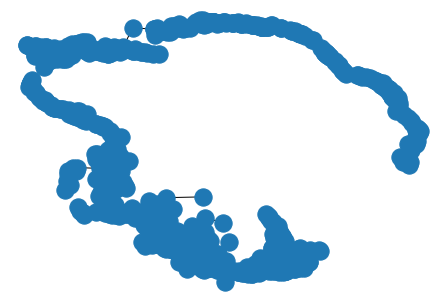

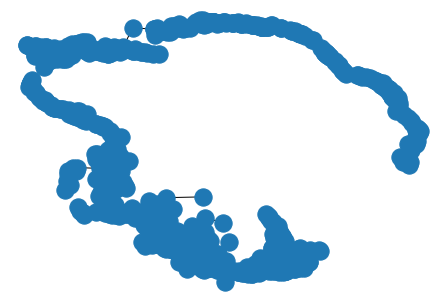

In [54]:
# Construct a MST only using the 750 points modified above
#points_centerline = np.load('archive_npyfile/demoCenterline.npy')
(graph_centerline, pointsCor3D_centerline) = getMSTFromDataPoint(points_centerline, drawMST=True, sampleNumber=750)  

# constantly delete the node that only has one edge, until there are only two nodes only having one edge left,
# both of them are the endpoints of one singal path representing the colon

toRemove = []
removeCount = 0
removedNodeDict = defaultdict(list)

print("MST has", len(pointsCor3D_centerline), "nodes. Now begin to trim the graph.")

while (True):
    toRemove = []
    for node in graph_centerline.nodes():
        if(len(graph_centerline.edges(node)) == 1):
            removedNodeDict[list(graph_centerline.edges(node))[0][1]].append(node)
            toRemove.append(node)
    if(len(toRemove) == 2):
        break
    for node in toRemove:
        graph_centerline.remove_node(node)
        removeCount += 1
        
        
endpoints = toRemove
print("Done! Trimed", removeCount, "nodes. Now MST has", len(graph_centerline.nodes), "nodes left.")

print("Now begin reconstruct endpoints")
# now add back the nodes that got deleted during the triming
addBackChildren(endpoints[0], 0)
addBackChildren(endpoints[1], 0)

print("Done! Now MST has", len(graph_centerline.nodes), "nodes left.")
# Displat the points on the centerline
'''
to_display = []
for node in graph_centerline.nodes:
    to_display.append(pointsCor3D_centerline[node])
displayPoints(to_display, 1.3)
'''
# check if there is more than 2 endpoints
new_endpoints = []
for node in graph_centerline.nodes:
    if(len(graph_centerline.edges(node)) == 1):
       new_endpoints.append(node)
if(len(new_endpoints) != 2):
    print("Fatal error: multiple endpoints detected!")

# check if there is more than 2 path
path = list(nx.all_simple_paths(graph_centerline, source=new_endpoints[0], target=new_endpoints[1]))
if(len(path) != 1):
    print("Fatal error: multiple path detected!")
    
pointsInorder = path[0]

In [49]:
c = curve()
for pointIndex in pointsInorder:
    c.append(pointCorToVector(pointsCor3D_centerline[pointIndex]))

In [50]:
toDisplay=[]
for node in graph_centerline.nodes():
    toDisplay.append(pointsCor3D_centerline[node])
displayPoints(toDisplay, 1.3)